In [1]:
from db import Database
import processing as proc
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import sklearn

logger = proc.setupLog()

In [2]:

#format for graphs to work with dark themed notebook
COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
#end formatting
records = Database("bank_data")
smallerTable = "people"
largerTable = "people_additional"
print(records.getEntries('people',0,1))
print(records.getSize("people"))
"""
TABLE people (
id INT AUTO_INCREMENT,
age TINYINT,
job CHAR(1),
maritial CHAR(1),
education CHAR(1),
isDefault CHAR(1),
balance INT,
housing CHAR(1),
loan CHAR(1),
contact CHAR(1),
day TINYINT,
month TINYINT,
duration SMALLINT,
campaign TINYINT,
pdays SMALLINT,
previous SMALLINT,
poutcome CHAR(1),
y CHAR(1),
"""

Connected to db
Successful SQL commands are printed on execution.
USE bank_data
(58, 'M', 'M', 'T', 'N', 2143, 'Y', 'N', '?', 5, 5, 261, 1, -1, 0, '?', 'N')
90422


'\nTABLE people (\nid INT AUTO_INCREMENT,\nage TINYINT,\njob CHAR(1),\nmaritial CHAR(1),\neducation CHAR(1),\nisDefault CHAR(1),\nbalance INT,\nhousing CHAR(1),\nloan CHAR(1),\ncontact CHAR(1),\nday TINYINT,\nmonth TINYINT,\nduration SMALLINT,\ncampaign TINYINT,\npdays SMALLINT,\nprevious SMALLINT,\npoutcome CHAR(1),\ny CHAR(1),\n'

In [3]:
#first just examine frequency of 'y'
numPeople = records.getSize('people')
numPeopleAdditional = records.getSize('people_additional')
peopleOut = records.getEntriesByField('people',0,numPeople,'y')
peopleAdditionalOut = records.getEntriesByField('people_additional',0,numPeopleAdditional,'y')

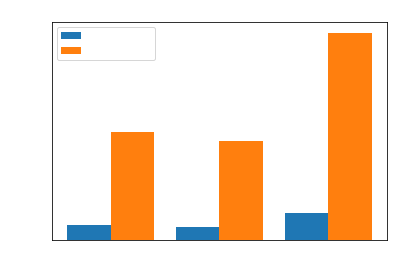

In the abbreviated dataset a purchase occured 11.70% of the time.
In the full dataset a purchase occured 11.27% of the time.
In the combined dataset a purchase occured 11.49% of the time.


In [4]:
#print out buying frequency
peopleBuy = 0

for char in peopleOut:
    if char == 'Y': peopleBuy+=1
peopleAdditionalBuy = 0
for char in peopleAdditionalOut:
    if char == 'Y': peopleAdditionalBuy+=1

buys = (peopleBuy,peopleAdditionalBuy,peopleBuy+peopleAdditionalBuy)
notBuys = (numPeople-buys[0],numPeopleAdditional-buys[1],numPeople+numPeopleAdditional-buys[2])

ind = [ i for i in range(3)]
width = .4
plt.figure(1)
plt.bar(ind,buys,width,label= 'Purchase')
plt.bar([item+width for item in ind],notBuys,width,label='No Purchase')
plt.title('Purchase frequency by dataset')
plt.xticks([item+width/2 for item in ind],('abbreviated dataset','full dataset', 'overall'))
plt.legend(loc='best')
plt.show()

print("In the abbreviated dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[0])/float(numPeople) )*100 ) )
print("In the full dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[1])/float(numPeopleAdditional) )*100 ) )
print("In the combined dataset a purchase occured {:.2f}% of the time.".format(
     ( float(buys[2])/float(numPeople+numPeopleAdditional) )*100 ) )


In [5]:
#get data dictionaries for processing
peopleMap, peopleAdditionalMap = records.getMaps()




In [6]:

#sql entries
line = records.getEntries('people',0,numPeople)
#translate to human-readable dataframe (similar to original csv)
df = proc.getDataFrame(line,peopleMap)
#see validate for more details, basically ensures all categories accounted for properly
proc.validate(df,peopleMap)

vec = proc.getOneHot(df,peopleMap,False)

#duration is not known until outcome is known
#see dataset documentation for more info
vec = vec.drop('duration',axis=1)



lineA = records.getEntries('people_additional',0,numPeopleAdditional)
dfa = proc.getDataFrame(lineA,peopleAdditionalMap)
proc.validate(dfa,peopleAdditionalMap)
#dfa = dfa.drop('duration',axis=1)
vecA = proc.getOneHot(dfa,peopleAdditionalMap,False)

vecA = vecA.drop('duration',axis=1)


#rand generator
randomGenr = np.random.default_rng()

#get cols
colTitles = vec.columns
colTitlesA = vecA.columns
#get processing array
dataOneHot = vec.to_numpy(dtype=np.float64)
dataOneHotA = vecA.to_numpy(dtype=np.float64)

##practice  run:


In [7]:
numTrees = 1000
for i in range(5):
    print('trial: {}'.format(i))
    
    #generate models
    treeModel = RandomForestClassifier(n_estimators=numTrees)
    treeModelA = RandomForestClassifier(n_estimators=numTrees)
    

    #get datasets 
    dataP = dataOneHot
    dataA = dataOneHotA
        
    #shuffle data
    randomGenr.shuffle(dataP)
    randomGenr.shuffle(dataA)
    
    #extract features, set float
    features = dataP[:,:-1].astype(np.float64)
    featuresA = dataA[:,:-1].astype(np.float64)
    
    #extract labels
    labels = dataP[:,-1]
    labelsA = dataA[:,-1]
    

    #get ~10% of indices as random choice WITHOUT replacement for test
    testIndices = randomGenr.choice(len(labels),size=int(len(labels)*.1),replace=False)
    testIndicesA = randomGenr.choice(len(labelsA),size=int(len(labelsA)*.1),replace=False)
    
    #take test items
    testLabels = np.take(labels,testIndices)
    testFeatures = np.take(features,testIndices,axis=0)
    testLabelsA = np.take(labelsA,testIndicesA)
    testFeaturesA = np.take(featuresA,testIndicesA,axis=0)

    #remove test items
    trainLabels = np.delete(labels,testIndices)
    trainFeatures = np.delete(features,testIndices,axis=0)
    trainLabelsA = np.delete(labelsA,testIndicesA)
    trainFeaturesA = np.delete(featuresA,testIndicesA,axis=0)

    #fit models
    treeModel.fit(trainFeatures,trainLabels)
    treeModelA.fit(trainFeaturesA,trainLabelsA)
 
    #get predictions
    treePredictions = treeModel.predict(testFeatures)
    treePredictionsA = treeModelA.predict(testFeaturesA)
    
    #get model probability score for predictions
    treeProbs = treeModel.predict_proba(testFeatures)
    treeProbsA = treeModel.predict_proba(testFeatures)
    
    #get feature importance, using permutation_importance (issues possible )
    bunch = permutation_importance(treeModel, testFeatures, testLabels, n_repeats=10)
    bunchA = permutation_importance(treeModelA, testFeaturesA, testLabelsA, n_repeats=10)
    
    #Save records for later processing
    #TODO: vectorize np writes
    np.save('./np/actual/actual_{}'.format(i),testLabels)
    np.save('./np/actual/actual_add_{}'.format(i),testLabelsA)
    
    np.save('./np/rafo/prediction_{}_{}'.format(i,numTrees),treePredictions)
    np.save('./np/rafo/tree_proba_{}_{}'.format(i,numTrees),treeProbs)
    
    np.save('./np/rafo/prediction_add_{}_{}'.format(i,numTrees),treePredictionsA)
    np.save('./np/rafo/tree_proba_add_{}_{}'.format(i,numTrees),treeProbsA)
    
    for key in bunch.keys():
        np.save('./np/rafo/perm_import_{}_{}'.format(i,key),bunch[key])
        np.save('./np/rafo/perm_import_add_{}_{}'.format(i,key),bunchA[key])
        
print('done')
    
    


trial: 0
trial: 1
trial: 2
trial: 3
trial: 4
done


In [14]:
#TODO: vectorize np reads
forestPred = np.array([])
forestProb = np.array([])
actual = np.array([])
forestPredA = np.array([])
forestProbA = np.array([])
actualA = np.array([])
bunches = np.array([])
bunchesA = np.array([])



for i in range(5):

    if(i==0):
        actual = [np.load('./np/actual/actual_{}.npy'.format(i))]
        forestPred = [np.load('./np/rafo/prediction_{}_{}.npy'.format(i,numTrees))]
        forestProb = [np.load('./np/rafo/tree_proba_{}_{}.npy'.format(i,numTrees))]
        
        actualA = [np.load('./np/actual/actual_add_{}.npy'.format(i))]
        forestPredA = [np.load('./np/rafo/prediction_add_{}_{}.npy'.format(i,numTrees))]
        forestProbA = [np.load('./np/rafo/tree_proba_add_{}_{}.npy'.format(i,numTrees))]

    else:
        actual = np.append(actual,[np.load('./np/actual/actual_{}.npy'.format(i))],axis=0)
        forestPred = np.append(forestPred,[np.load('./np/rafo/prediction_{}_{}.npy'.format(i,numTrees))],axis=0)
        forestProb = np.append(forestProb,[np.load('./np/rafo/tree_proba_{}_{}.npy'.format(i,numTrees))],axis=0)
        actualA = np.append(actualA,[np.load('./np/actual/actual_add_{}.npy'.format(i))],axis=0)
        forestPredA = np.append(forestPredA,[np.load('./np/rafo/prediction_add_{}_{}.npy'.format(i,numTrees))],axis=0)
        forestProbA = np.append(forestProbA,[np.load('./np/rafo/tree_proba_add_{}_{}.npy'.format(i,numTrees))],axis=0)

    for key in ['importances','importances_mean','importances_std']:
        bunch = dict()
        bunchA = dict()
        if(i==0):
            bunch[key] = np.load('/Users/jake/proj/tele_pred/np/rafo_incl_dur/perm_import_{}_{}.npy'.format(i,key))
            bunchA[key] = np.load('/Users/jake/proj/tele_pred/np/rafo_incl_dur/perm_import_add_{}_{}.npy'.format(i,key))
    np.append(bunches,bunch)
    np.append(bunchesA,bunchA)

In [9]:
#might be able to base (some) vectorization of redundant stuff above off this loop
corrects = []
wrongs = []
for i in range(2):
    c = []
    #this is the probability(y=1)
    w = []
    for ac,fo,pr in zip(actual,forestPred,forestProb):
        #[trueNegative,truePositive,averageProb]
        correct = [0,0,0]
        #[falseNegative,falsePositive,averageProb]
        wrong = [0,0,0]
        for a,f,p in zip(ac,fo,pr):
            if a == f:
                correct[int(a)]+=1
                correct[2]+=p[int(f)]
            else:
                wrong[int(a)]+=1
                wrong[2]+=p[int(f)]
        
        correct[2] = correct[2]/(correct[0]+correct[1])
        wrong[2] = wrong[2]/(wrong[0]+wrong[1])
        c.append(correct)
        w.append(wrong)
    corrects.append(c)
    wrongs.append(w)

In [10]:
logger.info('Duration feature has been removed for these runs:')
for co,wr in zip(corrects,wrongs):
    i=0
    for c,w in zip(co,wr):
        if i==0:
            logger.info("RUN NUMBER: {}, number of trees: {}, standard feature set".format(i,numTrees))
        else:
            logger.info("RUN NUMBER: {}, number of trees: {}, extended feature set".format(i,numTrees))
    
        logger.info("{} TRUE POSITIVES".format(c[1]))
        logger.info("{} TRUE NEGATIVES".format(c[0]))
        logger.info("{} FALSE POSITIVES".format(w[0]))
        logger.info("{} FALSE NEGATIVES".format(w[1]))
        logger.info('correct {}% of the time with average confidence={}'.format((100*(c[0]+c[1])/(w[0]+w[1]+c[0]+c[1])),c[2]))
        logger.info('wrong {}% of the time with average confidence={}'.format((100*(w[0]+w[1])/(w[0]+w[1]+c[0]+c[1])),w[2]))
        logger.info('\n---')
        i+=1
    
        

In [11]:
for a in zip(zip(actual,actualA),zip(forestProbA)
        forestPred = np.append(forestPred,[np.load('./np/rafo/prediction_{}_{}.npy'.format(i,numTrees))],axis=0)
        forestProb = np.append(forestProb,[np.load('./np/rafo/tree_proba_{}_{}.npy'.format(i,numTrees))],axis=0)
        actualA = np.append(actualA,[np.load('./np/actual/actual_add_{}.npy'.format(i))],axis=0)
        forestPredA = np.append(forestPredA,[np.load('./np/rafo/prediction_add_{}_{}.npy'.format(i,numTrees))],axis=0)
        forestProbA = np.append(forestProbA,[np.load('./np/rafo/tree_proba_add_{}_{}.npy'.format(i,numTrees))],axis=0)

0.0: [0.977 0.023]
0.0: [1. 0.]
0.0: [0.927 0.073]
0.0: [0.982 0.018]
0.0: [0.791 0.209]
0.0: [0.992 0.008]
0.0: [0.986 0.014]
0.0: [0.995 0.005]
0.0: [0.984 0.016]
0.0: [0.987 0.013]
0.0: [0.99 0.01]
0.0: [0.854 0.146]
0.0: [0.907 0.093]
0.0: [0.84 0.16]
0.0: [0.853 0.147]
1.0: [0.253 0.747]
0.0: [0.905 0.095]
0.0: [0.999 0.001]
0.0: [0.968 0.032]
0.0: [0.998 0.002]
0.0: [0.998 0.002]
1.0: [0.359 0.641]
0.0: [1. 0.]
1.0: [0.292 0.708]
0.0: [0.973 0.027]
0.0: [0.95 0.05]
0.0: [0.963 0.037]
0.0: [0.983 0.017]
0.0: [0.998 0.002]
0.0: [0.969 0.031]
0.0: [0.987 0.013]
0.0: [0.99 0.01]
0.0: [0.923 0.077]
0.0: [0.986 0.014]
0.0: [0.979 0.021]
0.0: [0.993 0.007]
1.0: [0.359 0.641]
0.0: [0.926 0.074]
0.0: [0.771 0.229]
0.0: [0.948 0.052]
0.0: [0.99 0.01]
0.0: [0.98 0.02]
0.0: [0.995 0.005]
0.0: [0.905 0.095]
0.0: [0.969 0.031]
0.0: [0.996 0.004]
1.0: [0.357 0.643]
0.0: [0.986 0.014]
0.0: [0.988 0.012]
0.0: [0.977 0.023]
0.0: [0.854 0.146]
0.0: [0.976 0.024]
0.0: [0.986 0.014]
0.0: [0.974 0.026

0.0: [0.907 0.093]
0.0: [0.747 0.253]
0.0: [0.987 0.013]
1.0: [0.342 0.658]
1.0: [0.362 0.638]
0.0: [0.988 0.012]
1.0: [0.402 0.598]
0.0: [0.889 0.111]
0.0: [0.995 0.005]
0.0: [0.997 0.003]
0.0: [0.977 0.023]
0.0: [0.926 0.074]
0.0: [0.851 0.149]
0.0: [0.974 0.026]
0.0: [0.994 0.006]
0.0: [0.911 0.089]
0.0: [0.891 0.109]
0.0: [0.99 0.01]
0.0: [0.863 0.137]
0.0: [0.993 0.007]
0.0: [0.907 0.093]
0.0: [0.988 0.012]
0.0: [0.983 0.017]
0.0: [1. 0.]
0.0: [0.963 0.037]
0.0: [0.986 0.014]
0.0: [0.92 0.08]
0.0: [0.941 0.059]
1.0: [0.171 0.829]
0.0: [0.946 0.054]
0.0: [1. 0.]
1.0: [0.312 0.688]
0.0: [0.988 0.012]
1.0: [0.074 0.926]
0.0: [0.986 0.014]
0.0: [0.972 0.028]
0.0: [0.989 0.011]
0.0: [0.974 0.026]
0.0: [0.899 0.101]
0.0: [0.99 0.01]
0.0: [0.946 0.054]
1.0: [0.293 0.707]
0.0: [0.898 0.102]
0.0: [0.984 0.016]
0.0: [0.995 0.005]
1.0: [0.247 0.753]
0.0: [0.976 0.024]
0.0: [0.996 0.004]
0.0: [0.998 0.002]
0.0: [0.908 0.092]
0.0: [0.994 0.006]
0.0: [0.93 0.07]
0.0: [0.991 0.009]
1.0: [0.19 0.

0.0: [0.995 0.005]
0.0: [0.99 0.01]
0.0: [0.996 0.004]
0.0: [0.95 0.05]
0.0: [0.991 0.009]
0.0: [0.986 0.014]
0.0: [0.915 0.085]
1.0: [0.115 0.885]
0.0: [0.959 0.041]
0.0: [0.971 0.029]
0.0: [0.969 0.031]
0.0: [0.991 0.009]
0.0: [0.99 0.01]
0.0: [0.972 0.028]
0.0: [0.99 0.01]
1.0: [0.271 0.729]
0.0: [0.931 0.069]
0.0: [0.979 0.021]
0.0: [0.963 0.037]
0.0: [0.992 0.008]
0.0: [0.969 0.031]
0.0: [0.975 0.025]
0.0: [0.998 0.002]
0.0: [0.997 0.003]
0.0: [0.91 0.09]
0.0: [0.998 0.002]
0.0: [0.995 0.005]
0.0: [0.991 0.009]
1.0: [0.282 0.718]
0.0: [0.896 0.104]
0.0: [0.994 0.006]
0.0: [0.984 0.016]
0.0: [0.964 0.036]
0.0: [1. 0.]
0.0: [0.988 0.012]
0.0: [0.966 0.034]
0.0: [0.969 0.031]
0.0: [0.975 0.025]
0.0: [0.992 0.008]
0.0: [0.974 0.026]
0.0: [0.989 0.011]
0.0: [0.968 0.032]
0.0: [0.902 0.098]
1.0: [0.241 0.759]
0.0: [0.908 0.092]
0.0: [0.945 0.055]
0.0: [1. 0.]
0.0: [0.983 0.017]
0.0: [0.968 0.032]
0.0: [0.932 0.068]
0.0: [0.997 0.003]
0.0: [0.993 0.007]
0.0: [0.978 0.022]
0.0: [0.959 0.0

0.0: [0.686 0.314]
0.0: [0.891 0.109]
0.0: [0.982 0.018]
0.0: [0.998 0.002]
0.0: [0.983 0.017]
1.0: [0.339 0.661]
0.0: [0.923 0.077]
0.0: [0.919 0.081]
0.0: [0.928 0.072]
0.0: [0.991 0.009]
0.0: [0.997 0.003]
0.0: [0.97 0.03]
0.0: [0.996 0.004]
0.0: [0.949 0.051]
0.0: [0.972 0.028]
0.0: [0.895 0.105]
0.0: [0.995 0.005]
0.0: [0.978 0.022]
1.0: [0.186 0.814]
0.0: [0.999 0.001]
0.0: [0.98 0.02]
0.0: [0.971 0.029]
0.0: [0.984 0.016]
1.0: [0.194 0.806]
0.0: [0.924 0.076]
0.0: [0.999 0.001]
0.0: [0.996 0.004]
0.0: [0.997 0.003]
0.0: [0.98 0.02]
0.0: [0.992 0.008]
0.0: [0.98 0.02]
0.0: [0.973 0.027]
0.0: [0.689 0.311]
0.0: [0.989 0.011]
0.0: [0.914 0.086]
0.0: [0.959 0.041]
1.0: [0.209 0.791]
0.0: [0.977 0.023]
0.0: [1. 0.]
0.0: [0.99 0.01]
0.0: [0.991 0.009]
0.0: [0.986 0.014]
0.0: [0.994 0.006]
0.0: [0.994 0.006]
0.0: [0.996 0.004]
1.0: [0.457 0.543]
0.0: [0.846 0.154]
0.0: [0.991 0.009]
1.0: [0.322 0.678]
0.0: [0.995 0.005]
0.0: [0.984 0.016]
0.0: [0.868 0.132]
0.0: [0.974 0.026]
0.0: [0.8

0.0: [0.998 0.002]
0.0: [0.984 0.016]
0.0: [0.999 0.001]
0.0: [0.995 0.005]
0.0: [0.976 0.024]
0.0: [0.819 0.181]
0.0: [0.916 0.084]
0.0: [0.999 0.001]
0.0: [0.965 0.035]
0.0: [0.979 0.021]
0.0: [0.952 0.048]
0.0: [0.867 0.133]
0.0: [0.997 0.003]
0.0: [0.999 0.001]
0.0: [0.994 0.006]
0.0: [0.981 0.019]
0.0: [0.987 0.013]
1.0: [0.074 0.926]
0.0: [0.979 0.021]
0.0: [0.862 0.138]
0.0: [0.971 0.029]
0.0: [0.999 0.001]
0.0: [0.979 0.021]
1.0: [0.186 0.814]
1.0: [0.221 0.779]
0.0: [0.975 0.025]
1.0: [0.352 0.648]
0.0: [0.994 0.006]
0.0: [0.992 0.008]
0.0: [0.966 0.034]
0.0: [0.992 0.008]
1.0: [0.006 0.994]
0.0: [0.971 0.029]
0.0: [0.992 0.008]
0.0: [0.985 0.015]
0.0: [0.994 0.006]
0.0: [0.993 0.007]
0.0: [0.955 0.045]
0.0: [0.923 0.077]
0.0: [0.981 0.019]
0.0: [0.937 0.063]
0.0: [0.976 0.024]
1.0: [0.229 0.771]
1.0: [0.344 0.656]
0.0: [0.995 0.005]
0.0: [0.853 0.147]
0.0: [0.986 0.014]
0.0: [1. 0.]
0.0: [0.977 0.023]
0.0: [0.943 0.057]
0.0: [0.888 0.112]
0.0: [0.993 0.007]
0.0: [0.945 0.055]

0.0: [0.963 0.037]
0.0: [0.934 0.066]
0.0: [0.935 0.065]
0.0: [0.993 0.007]
0.0: [0.985 0.015]
0.0: [0.983 0.017]
0.0: [0.981 0.019]
1.0: [0.287 0.713]
0.0: [0.952 0.048]
0.0: [0.985 0.015]
0.0: [0.999 0.001]
0.0: [0.996 0.004]
0.0: [0.985 0.015]
0.0: [0.89 0.11]
0.0: [0.991 0.009]
0.0: [0.784 0.216]
0.0: [0.974 0.026]
0.0: [0.999 0.001]
0.0: [0.801 0.199]
0.0: [0.996 0.004]
0.0: [0.954 0.046]
0.0: [0.984 0.016]
0.0: [0.926 0.074]
0.0: [0.929 0.071]
0.0: [0.871 0.129]
0.0: [0.969 0.031]
0.0: [0.96 0.04]
0.0: [0.886 0.114]
1.0: [0.342 0.658]
0.0: [0.996 0.004]
0.0: [0.982 0.018]
0.0: [1. 0.]
0.0: [0.972 0.028]
0.0: [0.994 0.006]
0.0: [1. 0.]
0.0: [0.99 0.01]
0.0: [0.982 0.018]
1.0: [0.213 0.787]
1.0: [0.325 0.675]
0.0: [0.993 0.007]
0.0: [0.939 0.061]
0.0: [0.729 0.271]
0.0: [0.995 0.005]
0.0: [0.969 0.031]
0.0: [0.937 0.063]
0.0: [0.997 0.003]
0.0: [0.869 0.131]
0.0: [0.958 0.042]
0.0: [0.962 0.038]
0.0: [0.962 0.038]
0.0: [0.991 0.009]
0.0: [0.995 0.005]
0.0: [1. 0.]
0.0: [0.995 0.005

0.0: [0.951 0.049]
0.0: [0.977 0.023]
0.0: [0.985 0.015]
0.0: [0.982 0.018]
0.0: [0.985 0.015]
1.0: [0.345 0.655]
0.0: [0.988 0.012]
0.0: [0.95 0.05]
0.0: [0.993 0.007]
0.0: [0.951 0.049]
0.0: [0.954 0.046]
0.0: [0.935 0.065]
1.0: [0.211 0.789]
0.0: [0.971 0.029]
1.0: [0.291 0.709]
0.0: [0.998 0.002]
0.0: [0.949 0.051]
0.0: [0.95 0.05]
0.0: [0.963 0.037]
0.0: [0.952 0.048]
0.0: [0.989 0.011]
0.0: [0.997 0.003]
0.0: [0.986 0.014]
0.0: [0.962 0.038]
0.0: [0.924 0.076]
0.0: [1. 0.]
0.0: [0.895 0.105]
0.0: [0.995 0.005]
0.0: [0.977 0.023]
0.0: [0.986 0.014]
1.0: [0.344 0.656]
0.0: [0.997 0.003]
0.0: [0.953 0.047]
0.0: [0.997 0.003]
0.0: [0.993 0.007]
0.0: [0.956 0.044]
0.0: [0.995 0.005]
0.0: [0.91 0.09]
0.0: [1. 0.]
0.0: [0.995 0.005]
0.0: [0.995 0.005]
0.0: [0.934 0.066]
0.0: [0.982 0.018]
0.0: [0.98 0.02]
0.0: [0.956 0.044]
0.0: [0.984 0.016]
0.0: [0.881 0.119]
0.0: [0.985 0.015]
0.0: [0.998 0.002]
1.0: [0.361 0.639]
0.0: [0.95 0.05]
0.0: [0.987 0.013]
1.0: [0.321 0.679]
0.0: [0.894 0.1

0.0: [0.995 0.005]
0.0: [0.993 0.007]
0.0: [0.968 0.032]
0.0: [0.956 0.044]
0.0: [0.969 0.031]
0.0: [0.988 0.012]
0.0: [0.983 0.017]
0.0: [0.753 0.247]
0.0: [1. 0.]
0.0: [0.973 0.027]
0.0: [0.965 0.035]
0.0: [0.979 0.021]
0.0: [0.985 0.015]
0.0: [0.998 0.002]
0.0: [0.992 0.008]
0.0: [0.991 0.009]
1.0: [0.154 0.846]
0.0: [1. 0.]
0.0: [0.977 0.023]
1.0: [0.076 0.924]
0.0: [0.986 0.014]
0.0: [0.957 0.043]
0.0: [0.967 0.033]
0.0: [0.991 0.009]
0.0: [0.987 0.013]
0.0: [0.976 0.024]
0.0: [0.973 0.027]
0.0: [0.969 0.031]
0.0: [0.997 0.003]
0.0: [0.995 0.005]
0.0: [0.95 0.05]
0.0: [0.995 0.005]
0.0: [0.925 0.075]
0.0: [0.999 0.001]
0.0: [0.965 0.035]
0.0: [0.814 0.186]
0.0: [0.918 0.082]
0.0: [0.998 0.002]
0.0: [0.969 0.031]
0.0: [0.968 0.032]
0.0: [0.968 0.032]
0.0: [0.963 0.037]
0.0: [0.99 0.01]
0.0: [0.884 0.116]
0.0: [0.999 0.001]
0.0: [0.984 0.016]
0.0: [0.978 0.022]
0.0: [0.988 0.012]
1.0: [0.303 0.697]
0.0: [1. 0.]
0.0: [0.99 0.01]
0.0: [0.994 0.006]
0.0: [1. 0.]
0.0: [0.969 0.031]
0.0:

0.0: [0.914 0.086]
1.0: [0.207 0.793]
0.0: [0.991 0.009]
0.0: [0.988 0.012]
0.0: [0.99 0.01]
0.0: [0.996 0.004]
1.0: [0.155 0.845]
0.0: [0.993 0.007]
0.0: [0.987 0.013]
0.0: [0.992 0.008]
0.0: [0.981 0.019]
0.0: [0.814 0.186]
0.0: [0.869 0.131]
0.0: [0.969 0.031]
0.0: [0.998 0.002]
0.0: [0.996 0.004]
0.0: [0.973 0.027]
1.0: [0.162 0.838]
0.0: [0.978 0.022]
0.0: [0.994 0.006]
0.0: [0.997 0.003]
0.0: [0.94 0.06]
0.0: [0.999 0.001]
0.0: [0.962 0.038]
0.0: [0.993 0.007]
0.0: [0.991 0.009]
0.0: [0.99 0.01]
0.0: [0.997 0.003]
0.0: [0.848 0.152]
1.0: [0.379 0.621]
0.0: [0.961 0.039]
0.0: [0.991 0.009]
0.0: [0.971 0.029]
0.0: [0.982 0.018]
0.0: [0.986 0.014]
0.0: [0.993 0.007]
0.0: [0.868 0.132]
0.0: [0.976 0.024]
0.0: [0.985 0.015]
0.0: [0.927 0.073]
0.0: [0.982 0.018]
0.0: [0.973 0.027]
0.0: [0.979 0.021]
0.0: [0.978 0.022]
0.0: [0.977 0.023]
0.0: [0.993 0.007]
0.0: [0.998 0.002]
0.0: [0.989 0.011]
0.0: [0.976 0.024]
0.0: [0.993 0.007]
1.0: [0.189 0.811]
0.0: [0.99 0.01]
0.0: [0.978 0.022]
0

0.0: [0.96 0.04]
0.0: [0.995 0.005]
0.0: [0.999 0.001]
0.0: [0.971 0.029]
0.0: [0.959 0.041]
0.0: [0.762 0.238]
0.0: [0.919 0.081]
0.0: [0.989 0.011]
1.0: [0.255 0.745]
0.0: [0.973 0.027]
0.0: [0.97 0.03]
0.0: [0.982 0.018]
0.0: [1. 0.]
0.0: [0.96 0.04]
0.0: [0.89 0.11]
0.0: [0.981 0.019]
0.0: [0.919 0.081]
0.0: [0.981 0.019]
1.0: [0.297 0.703]
0.0: [0.958 0.042]
0.0: [0.94 0.06]
0.0: [0.991 0.009]
0.0: [0.968 0.032]
0.0: [0.983 0.017]
0.0: [0.993 0.007]
0.0: [0.989 0.011]
0.0: [0.989 0.011]
0.0: [0.977 0.023]
1.0: [0.179 0.821]
0.0: [0.947 0.053]
0.0: [0.989 0.011]
0.0: [0.981 0.019]
0.0: [0.991 0.009]
0.0: [0.944 0.056]
1.0: [0.336 0.664]
0.0: [0.993 0.007]
1.0: [0.025 0.975]
0.0: [0.936 0.064]
0.0: [0.997 0.003]
0.0: [0.957 0.043]
0.0: [0.977 0.023]
0.0: [0.977 0.023]
0.0: [0.989 0.011]
1.0: [0.327 0.673]
0.0: [0.97 0.03]
1.0: [0.296 0.704]
0.0: [0.982 0.018]
0.0: [0.973 0.027]
0.0: [0.992 0.008]
0.0: [0.992 0.008]
0.0: [0.948 0.052]
0.0: [0.981 0.019]
0.0: [0.997 0.003]
0.0: [0.994

0.0: [0.993 0.007]
0.0: [0.974 0.026]
0.0: [0.833 0.167]
0.0: [0.956 0.044]
0.0: [0.964 0.036]
0.0: [0.999 0.001]
0.0: [0.997 0.003]
0.0: [0.997 0.003]
0.0: [0.945 0.055]
0.0: [0.984 0.016]
0.0: [0.999 0.001]
0.0: [0.991 0.009]
0.0: [0.997 0.003]
0.0: [0.988 0.012]
0.0: [0.919 0.081]
0.0: [0.972 0.028]
0.0: [0.977 0.023]
0.0: [0.993 0.007]
0.0: [0.996 0.004]
0.0: [0.936 0.064]
0.0: [0.977 0.023]
0.0: [0.998 0.002]
1.0: [0.343 0.657]
0.0: [0.977 0.023]
0.0: [0.996 0.004]
0.0: [0.89 0.11]
1.0: [0.329 0.671]
0.0: [0.996 0.004]
1.0: [0.359 0.641]
0.0: [0.993 0.007]
0.0: [0.984 0.016]
0.0: [0.894 0.106]
1.0: [0.151 0.849]
0.0: [0.897 0.103]
0.0: [0.95 0.05]
0.0: [0.956 0.044]
0.0: [0.998 0.002]
1.0: [0.106 0.894]
0.0: [0.972 0.028]
0.0: [0.795 0.205]
0.0: [0.992 0.008]
0.0: [0.861 0.139]
1.0: [0.357 0.643]
0.0: [0.966 0.034]
0.0: [1. 0.]
0.0: [0.937 0.063]
0.0: [0.984 0.016]
1.0: [0.161 0.839]
0.0: [0.843 0.157]
0.0: [0.95 0.05]
0.0: [0.755 0.245]
1.0: [0.487 0.513]
0.0: [0.978 0.022]
0.0: 

0.0: [0.937 0.063]
1.0: [0.074 0.926]
0.0: [0.995 0.005]
0.0: [0.995 0.005]
0.0: [0.907 0.093]
0.0: [0.954 0.046]
0.0: [0.99 0.01]
0.0: [0.924 0.076]
0.0: [0.997 0.003]
0.0: [0.993 0.007]
0.0: [0.965 0.035]
0.0: [0.954 0.046]
1.0: [0.349 0.651]
0.0: [0.965 0.035]
1.0: [0.368 0.632]
0.0: [0.991 0.009]
1.0: [0.22 0.78]
0.0: [0.962 0.038]
0.0: [0.956 0.044]
0.0: [0.936 0.064]
0.0: [0.974 0.026]
0.0: [0.98 0.02]
0.0: [0.996 0.004]
0.0: [0.742 0.258]
0.0: [0.899 0.101]
0.0: [0.995 0.005]
0.0: [0.951 0.049]
0.0: [0.973 0.027]
0.0: [0.996 0.004]
0.0: [0.939 0.061]
0.0: [0.996 0.004]
0.0: [0.993 0.007]
0.0: [0.944 0.056]
0.0: [0.988 0.012]
0.0: [0.967 0.033]
0.0: [0.955 0.045]
1.0: [0.273 0.727]
0.0: [0.923 0.077]
0.0: [1. 0.]
0.0: [0.937 0.063]
0.0: [0.951 0.049]
0.0: [0.976 0.024]
0.0: [0.942 0.058]
0.0: [0.894 0.106]
0.0: [0.998 0.002]
0.0: [0.978 0.022]
0.0: [0.996 0.004]
0.0: [0.966 0.034]
0.0: [0.585 0.415]
0.0: [0.978 0.022]
0.0: [0.948 0.052]
0.0: [0.987 0.013]
0.0: [0.87 0.13]
0.0: [0

0.0: [0.997 0.003]
0.0: [0.998 0.002]
0.0: [0.98 0.02]
1.0: [0.142 0.858]
0.0: [0.994 0.006]
0.0: [0.758 0.242]
0.0: [0.928 0.072]
0.0: [0.976 0.024]
0.0: [0.962 0.038]
0.0: [0.918 0.082]
1.0: [0.194 0.806]
0.0: [0.984 0.016]
0.0: [0.993 0.007]
0.0: [0.984 0.016]
0.0: [0.829 0.171]
0.0: [0.964 0.036]
0.0: [0.898 0.102]
0.0: [0.987 0.013]
0.0: [0.88 0.12]
0.0: [0.999 0.001]
1.0: [0.366 0.634]
0.0: [0.983 0.017]
0.0: [0.993 0.007]
0.0: [0.983 0.017]
0.0: [0.979 0.021]
0.0: [0.93 0.07]
0.0: [0.998 0.002]
0.0: [0.989 0.011]
0.0: [0.971 0.029]
0.0: [0.989 0.011]
1.0: [0.331 0.669]
0.0: [0.979 0.021]
0.0: [0.931 0.069]
0.0: [0.942 0.058]
0.0: [0.987 0.013]
0.0: [0.994 0.006]
0.0: [0.748 0.252]
0.0: [0.962 0.038]
0.0: [0.927 0.073]
0.0: [0.904 0.096]
0.0: [0.983 0.017]
0.0: [0.917 0.083]
0.0: [0.969 0.031]
0.0: [0.974 0.026]
0.0: [0.986 0.014]
1.0: [0.187 0.813]
0.0: [0.976 0.024]
0.0: [0.977 0.023]
0.0: [0.9 0.1]
0.0: [0.989 0.011]
0.0: [0.933 0.067]
0.0: [0.98 0.02]
1.0: [0.377 0.623]
0.0: 

0.0: [0.984 0.016]
0.0: [0.982 0.018]
0.0: [0.953 0.047]
0.0: [0.992 0.008]
0.0: [1. 0.]
0.0: [0.977 0.023]
0.0: [0.959 0.041]
0.0: [0.954 0.046]
0.0: [0.971 0.029]
0.0: [0.993 0.007]
0.0: [0.808 0.192]
0.0: [0.838 0.162]
0.0: [0.981 0.019]
0.0: [0.987 0.013]
0.0: [0.994 0.006]
0.0: [0.999 0.001]
0.0: [0.881 0.119]
0.0: [0.96 0.04]
0.0: [0.982 0.018]
0.0: [0.54 0.46]
0.0: [0.866 0.134]
0.0: [0.976 0.024]
1.0: [0.231 0.769]
1.0: [0.225 0.775]
0.0: [0.979 0.021]
0.0: [0.973 0.027]
0.0: [0.992 0.008]
0.0: [0.998 0.002]
1.0: [0.192 0.808]
1.0: [0.22 0.78]
0.0: [0.999 0.001]
0.0: [0.951 0.049]
0.0: [0.881 0.119]
0.0: [0.976 0.024]
0.0: [0.995 0.005]
1.0: [0.14 0.86]
0.0: [0.996 0.004]
0.0: [1. 0.]
0.0: [0.933 0.067]
1.0: [0.367 0.633]
0.0: [0.982 0.018]
0.0: [1. 0.]
0.0: [0.967 0.033]
0.0: [0.981 0.019]
0.0: [0.986 0.014]
0.0: [0.973 0.027]
0.0: [0.968 0.032]
0.0: [0.979 0.021]
0.0: [0.998 0.002]
1.0: [0.374 0.626]
0.0: [0.99 0.01]
0.0: [0.982 0.018]
0.0: [0.976 0.024]
1.0: [0.31 0.69]
0.0:

0.0: [0.973 0.027]
0.0: [0.982 0.018]
0.0: [0.983 0.017]
0.0: [0.99 0.01]
0.0: [0.919 0.081]
0.0: [0.968 0.032]
1.0: [0.198 0.802]
0.0: [0.997 0.003]
0.0: [0.999 0.001]
0.0: [0.984 0.016]
0.0: [0.963 0.037]
0.0: [0.941 0.059]
0.0: [0.987 0.013]
0.0: [0.983 0.017]
0.0: [0.975 0.025]
0.0: [1. 0.]
0.0: [0.996 0.004]
0.0: [0.949 0.051]
1.0: [0.279 0.721]
0.0: [0.99 0.01]
0.0: [0.982 0.018]
0.0: [0.98 0.02]
0.0: [0.922 0.078]
1.0: [0.265 0.735]
0.0: [0.997 0.003]
0.0: [0.984 0.016]
0.0: [0.942 0.058]
0.0: [0.992 0.008]
0.0: [0.996 0.004]
0.0: [0.995 0.005]
0.0: [0.767 0.233]
0.0: [0.966 0.034]
0.0: [0.99 0.01]
0.0: [0.965 0.035]
0.0: [0.994 0.006]
0.0: [0.861 0.139]
0.0: [0.982 0.018]
0.0: [0.984 0.016]
0.0: [0.999 0.001]
1.0: [0.349 0.651]
0.0: [0.986 0.014]
0.0: [0.945 0.055]
0.0: [0.982 0.018]
0.0: [0.99 0.01]
0.0: [0.986 0.014]
0.0: [0.994 0.006]
0.0: [0.922 0.078]
0.0: [0.982 0.018]
0.0: [0.964 0.036]
0.0: [0.971 0.029]
0.0: [0.845 0.155]
0.0: [0.98 0.02]
0.0: [0.981 0.019]
0.0: [0.981

0.0: [0.992 0.008]
0.0: [0.967 0.033]
0.0: [0.989 0.011]
0.0: [0.922 0.078]
0.0: [0.989 0.011]
0.0: [0.978 0.022]
1.0: [0.231 0.769]
0.0: [0.929 0.071]
0.0: [0.98 0.02]
0.0: [0.974 0.026]
0.0: [0.769 0.231]
0.0: [0.965 0.035]
0.0: [0.943 0.057]
0.0: [0.922 0.078]
0.0: [0.987 0.013]
1.0: [0.286 0.714]
0.0: [0.988 0.012]
0.0: [0.956 0.044]
0.0: [0.71 0.29]
0.0: [0.869 0.131]
0.0: [0.717 0.283]
0.0: [0.982 0.018]
0.0: [0.942 0.058]
0.0: [0.916 0.084]
0.0: [0.993 0.007]
0.0: [0.994 0.006]
0.0: [0.963 0.037]
0.0: [0.989 0.011]
0.0: [0.984 0.016]
0.0: [0.996 0.004]
0.0: [0.981 0.019]
0.0: [0.972 0.028]
0.0: [0.981 0.019]
0.0: [0.949 0.051]
0.0: [0.982 0.018]
0.0: [0.986 0.014]
0.0: [0.998 0.002]
0.0: [0.999 0.001]
0.0: [0.92 0.08]
0.0: [0.997 0.003]
0.0: [0.915 0.085]
0.0: [0.991 0.009]
0.0: [0.977 0.023]
0.0: [0.94 0.06]
0.0: [0.707 0.293]
1.0: [0.144 0.856]
0.0: [0.949 0.051]
0.0: [0.973 0.027]
0.0: [0.975 0.025]
1.0: [0.06 0.94]
0.0: [0.986 0.014]
0.0: [0.998 0.002]
0.0: [0.975 0.025]
0.0

0.0: [0.993 0.007]
0.0: [0.908 0.092]
0.0: [0.972 0.028]
0.0: [0.94 0.06]
0.0: [0.948 0.052]
0.0: [0.978 0.022]
0.0: [0.99 0.01]
0.0: [0.993 0.007]
0.0: [0.958 0.042]
1.0: [0.299 0.701]
0.0: [0.898 0.102]
0.0: [0.987 0.013]
0.0: [0.976 0.024]
0.0: [0.918 0.082]
0.0: [0.98 0.02]
0.0: [0.997 0.003]
0.0: [0.98 0.02]
1.0: [0.359 0.641]
0.0: [0.889 0.111]
0.0: [0.982 0.018]
0.0: [0.844 0.156]
0.0: [0.982 0.018]
0.0: [1. 0.]
1.0: [0.309 0.691]
0.0: [0.998 0.002]
0.0: [0.986 0.014]
0.0: [0.977 0.023]
0.0: [0.974 0.026]
0.0: [0.999 0.001]
0.0: [0.806 0.194]
0.0: [0.985 0.015]
0.0: [0.993 0.007]
1.0: [0.339 0.661]
0.0: [0.979 0.021]
1.0: [0.383 0.617]
0.0: [0.863 0.137]
0.0: [0.99 0.01]
0.0: [0.979 0.021]
1.0: [0.291 0.709]
1.0: [0.363 0.637]
0.0: [0.972 0.028]
0.0: [0.997 0.003]
0.0: [0.993 0.007]
0.0: [0.978 0.022]
0.0: [0.954 0.046]
0.0: [0.997 0.003]
0.0: [0.991 0.009]
0.0: [0.98 0.02]
0.0: [0.965 0.035]
0.0: [0.933 0.067]
0.0: [0.99 0.01]
0.0: [0.985 0.015]
0.0: [0.985 0.015]
1.0: [0.157 0

0.0: [0.99 0.01]
0.0: [0.944 0.056]
1.0: [0.344 0.656]
0.0: [0.975 0.025]
0.0: [0.982 0.018]
0.0: [0.949 0.051]
0.0: [0.969 0.031]
0.0: [0.976 0.024]
0.0: [0.998 0.002]
0.0: [0.996 0.004]
0.0: [0.892 0.108]
0.0: [0.912 0.088]
0.0: [0.993 0.007]
0.0: [0.99 0.01]
0.0: [0.807 0.193]
0.0: [0.949 0.051]
1.0: [0.251 0.749]
0.0: [1. 0.]
0.0: [0.965 0.035]
1.0: [0.329 0.671]
0.0: [0.972 0.028]
0.0: [0.993 0.007]
0.0: [0.952 0.048]
0.0: [0.994 0.006]
0.0: [0.99 0.01]
0.0: [0.89 0.11]
0.0: [0.995 0.005]
1.0: [0.345 0.655]
0.0: [0.975 0.025]
0.0: [0.923 0.077]
0.0: [0.991 0.009]
0.0: [0.985 0.015]
0.0: [0.998 0.002]
1.0: [0.186 0.814]
0.0: [0.989 0.011]
0.0: [0.935 0.065]
0.0: [0.968 0.032]
0.0: [0.78 0.22]
0.0: [0.721 0.279]
0.0: [0.989 0.011]
1.0: [0.392 0.608]
0.0: [0.952 0.048]
0.0: [0.96 0.04]
0.0: [0.998 0.002]
0.0: [0.965 0.035]
0.0: [0.991 0.009]
0.0: [0.999 0.001]
0.0: [0.55 0.45]
0.0: [0.992 0.008]
1.0: [0.371 0.629]
0.0: [0.907 0.093]
0.0: [0.992 0.008]
0.0: [0.963 0.037]
0.0: [0.907 0

0.0: [0.965 0.035]
0.0: [0.976 0.024]
0.0: [0.906 0.094]
0.0: [0.962 0.038]
0.0: [0.974 0.026]
0.0: [0.972 0.028]
0.0: [0.994 0.006]
0.0: [0.989 0.011]
1.0: [0.15 0.85]
0.0: [0.996 0.004]
0.0: [0.987 0.013]
0.0: [0.942 0.058]
0.0: [0.995 0.005]
0.0: [0.937 0.063]
0.0: [0.993 0.007]
0.0: [0.999 0.001]
0.0: [0.976 0.024]
0.0: [0.996 0.004]
0.0: [0.841 0.159]
1.0: [0.265 0.735]
0.0: [0.987 0.013]
0.0: [0.984 0.016]
0.0: [0.925 0.075]
0.0: [0.997 0.003]
0.0: [0.949 0.051]
0.0: [0.963 0.037]
0.0: [0.991 0.009]
1.0: [0.223 0.777]
0.0: [0.964 0.036]
0.0: [0.984 0.016]
0.0: [0.918 0.082]
0.0: [0.997 0.003]
1.0: [0.267 0.733]
0.0: [0.991 0.009]
1.0: [0.167 0.833]
0.0: [0.899 0.101]
0.0: [0.995 0.005]
0.0: [0.95 0.05]
0.0: [0.935 0.065]
0.0: [0.892 0.108]
0.0: [0.931 0.069]
0.0: [0.994 0.006]
0.0: [0.846 0.154]
0.0: [0.995 0.005]
0.0: [0.993 0.007]
0.0: [0.99 0.01]
0.0: [0.956 0.044]
0.0: [0.918 0.082]
0.0: [0.977 0.023]
0.0: [0.98 0.02]
0.0: [0.999 0.001]
0.0: [0.987 0.013]
0.0: [0.983 0.017]
0

0.0: [0.995 0.005]
0.0: [0.979 0.021]
0.0: [0.962 0.038]
0.0: [0.99 0.01]
0.0: [0.738 0.262]
0.0: [0.964 0.036]
0.0: [0.999 0.001]
1.0: [0.342 0.658]
0.0: [0.972 0.028]
0.0: [0.973 0.027]
0.0: [0.992 0.008]
0.0: [0.997 0.003]
1.0: [0.066 0.934]
0.0: [0.833 0.167]
0.0: [0.969 0.031]
0.0: [0.977 0.023]
0.0: [0.999 0.001]
0.0: [0.995 0.005]
0.0: [0.936 0.064]
0.0: [0.996 0.004]
0.0: [0.959 0.041]
0.0: [0.951 0.049]
0.0: [0.91 0.09]
0.0: [0.798 0.202]
0.0: [0.997 0.003]
0.0: [0.924 0.076]
0.0: [0.952 0.048]
0.0: [0.965 0.035]
0.0: [0.96 0.04]
0.0: [0.939 0.061]
0.0: [0.95 0.05]
0.0: [0.971 0.029]
0.0: [0.865 0.135]
0.0: [0.992 0.008]
1.0: [0.368 0.632]
1.0: [0.375 0.625]
0.0: [0.889 0.111]
0.0: [0.951 0.049]
0.0: [0.989 0.011]
0.0: [0.96 0.04]
0.0: [0.959 0.041]
0.0: [0.988 0.012]
1.0: [0.241 0.759]
0.0: [0.911 0.089]
0.0: [0.987 0.013]
0.0: [0.867 0.133]
0.0: [0.994 0.006]
0.0: [1. 0.]
0.0: [0.941 0.059]
0.0: [0.836 0.164]
0.0: [0.992 0.008]
0.0: [0.988 0.012]
0.0: [0.955 0.045]
0.0: [0.9

0.0: [0.976 0.024]
0.0: [0.995 0.005]
1.0: [0.019 0.981]
0.0: [0.991 0.009]
1.0: [0.354 0.646]
0.0: [0.992 0.008]
0.0: [0.959 0.041]
0.0: [0.978 0.022]
1.0: [0.367 0.633]
1.0: [0.466 0.534]
1.0: [0.209 0.791]
0.0: [0.919 0.081]
0.0: [0.984 0.016]
0.0: [0.973 0.027]
0.0: [0.977 0.023]
0.0: [0.937 0.063]
0.0: [0.999 0.001]
0.0: [0.78 0.22]
0.0: [0.894 0.106]
0.0: [0.874 0.126]
1.0: [0.246 0.754]
0.0: [0.979 0.021]
0.0: [0.996 0.004]
0.0: [0.992 0.008]
0.0: [0.988 0.012]
0.0: [0.961 0.039]
0.0: [0.931 0.069]
0.0: [0.963 0.037]
0.0: [0.964 0.036]
0.0: [0.995 0.005]
0.0: [0.943 0.057]
0.0: [0.932 0.068]
0.0: [0.994 0.006]
0.0: [0.99 0.01]
1.0: [0.24 0.76]
0.0: [0.989 0.011]
0.0: [0.906 0.094]
0.0: [0.928 0.072]
0.0: [0.946 0.054]
1.0: [0.288 0.712]
0.0: [0.993 0.007]
0.0: [0.972 0.028]
0.0: [0.94 0.06]
1.0: [0.289 0.711]
0.0: [0.98 0.02]
0.0: [0.942 0.058]
1.0: [0.35 0.65]
0.0: [0.988 0.012]
0.0: [0.97 0.03]
0.0: [0.988 0.012]
1.0: [0.247 0.753]
1.0: [0.343 0.657]
0.0: [0.904 0.096]
0.0: [0

1.0: [0.33 0.67]
0.0: [0.929 0.071]
0.0: [0.987 0.013]
0.0: [0.98 0.02]
0.0: [0.992 0.008]
0.0: [1. 0.]
0.0: [0.994 0.006]
0.0: [0.983 0.017]
0.0: [0.97 0.03]
0.0: [0.98 0.02]
0.0: [0.985 0.015]
0.0: [0.628 0.372]
0.0: [0.95 0.05]
0.0: [0.933 0.067]
0.0: [0.98 0.02]
0.0: [0.998 0.002]
0.0: [0.952 0.048]
0.0: [0.997 0.003]
0.0: [0.985 0.015]
0.0: [0.99 0.01]
0.0: [0.997 0.003]
0.0: [0.996 0.004]
0.0: [0.972 0.028]
1.0: [0.299 0.701]
0.0: [0.999 0.001]
0.0: [0.98 0.02]
0.0: [0.916 0.084]
0.0: [0.974 0.026]
0.0: [0.979 0.021]
0.0: [0.963 0.037]
1.0: [0.203 0.797]
0.0: [0.91 0.09]
0.0: [0.95 0.05]
0.0: [0.974 0.026]
1.0: [0.173 0.827]
0.0: [0.882 0.118]
1.0: [0.246 0.754]
0.0: [0.987 0.013]
0.0: [0.996 0.004]
0.0: [0.995 0.005]
0.0: [0.979 0.021]
0.0: [0.962 0.038]
0.0: [0.953 0.047]
0.0: [0.982 0.018]
0.0: [1. 0.]
0.0: [0.998 0.002]
0.0: [0.952 0.048]
0.0: [0.954 0.046]
0.0: [0.919 0.081]
1.0: [0.334 0.666]
0.0: [0.968 0.032]
0.0: [0.994 0.006]
0.0: [0.97 0.03]
0.0: [0.9 0.1]
0.0: [0.999 

0.0: [0.984 0.016]
0.0: [0.977 0.023]
0.0: [0.967 0.033]
0.0: [0.998 0.002]
0.0: [0.99 0.01]
0.0: [0.968 0.032]
0.0: [0.933 0.067]
0.0: [0.986 0.014]
0.0: [0.988 0.012]
1.0: [0.262 0.738]
0.0: [0.994 0.006]
0.0: [0.981 0.019]
0.0: [0.796 0.204]
1.0: [0.137 0.863]
0.0: [0.993 0.007]
0.0: [0.989 0.011]
0.0: [0.976 0.024]
0.0: [0.958 0.042]
0.0: [0.93 0.07]
1.0: [0.277 0.723]
0.0: [1. 0.]
0.0: [0.997 0.003]
0.0: [0.995 0.005]
0.0: [0.997 0.003]
0.0: [0.995 0.005]
0.0: [0.945 0.055]
0.0: [0.937 0.063]
0.0: [0.989 0.011]
0.0: [0.93 0.07]
0.0: [0.992 0.008]
0.0: [0.982 0.018]
0.0: [0.989 0.011]
0.0: [0.877 0.123]
0.0: [0.845 0.155]
0.0: [0.967 0.033]
1.0: [0.304 0.696]
0.0: [0.995 0.005]
0.0: [0.954 0.046]
0.0: [0.94 0.06]
0.0: [0.988 0.012]
1.0: [0.384 0.616]
0.0: [0.999 0.001]
0.0: [0.994 0.006]
0.0: [0.969 0.031]
0.0: [0.903 0.097]
0.0: [0.907 0.093]
0.0: [1. 0.]
0.0: [0.97 0.03]
0.0: [0.971 0.029]
0.0: [0.985 0.015]
1.0: [0.321 0.679]
0.0: [0.992 0.008]
1.0: [0.303 0.697]
0.0: [0.951 0.0

0.0: [0.528 0.472]
0.0: [0.956 0.044]
0.0: [0.968 0.032]
0.0: [0.991 0.009]
0.0: [0.973 0.027]
0.0: [0.941 0.059]
0.0: [0.986 0.014]
0.0: [0.999 0.001]
0.0: [0.983 0.017]
0.0: [0.992 0.008]
0.0: [0.993 0.007]
0.0: [0.987 0.013]
0.0: [0.781 0.219]
0.0: [0.93 0.07]
0.0: [0.999 0.001]
0.0: [0.978 0.022]
0.0: [0.947 0.053]
0.0: [0.992 0.008]
0.0: [0.959 0.041]
0.0: [1. 0.]
0.0: [0.987 0.013]
0.0: [0.985 0.015]
0.0: [0.998 0.002]
0.0: [0.973 0.027]
0.0: [0.817 0.183]
0.0: [0.988 0.012]
0.0: [0.989 0.011]
1.0: [0.271 0.729]
0.0: [0.999 0.001]
0.0: [0.988 0.012]
0.0: [0.998 0.002]
0.0: [0.975 0.025]
0.0: [0.964 0.036]
0.0: [1. 0.]
0.0: [0.916 0.084]
0.0: [0.947 0.053]
0.0: [0.993 0.007]
0.0: [0.973 0.027]
0.0: [0.971 0.029]
0.0: [0.915 0.085]
0.0: [0.834 0.166]
0.0: [0.841 0.159]
0.0: [0.982 0.018]
0.0: [0.976 0.024]
0.0: [1. 0.]
0.0: [0.994 0.006]
0.0: [0.997 0.003]
0.0: [0.985 0.015]
0.0: [0.964 0.036]
0.0: [0.98 0.02]
0.0: [0.972 0.028]
0.0: [0.997 0.003]
0.0: [0.98 0.02]
0.0: [0.973 0.027

0.0: [0.965 0.035]
0.0: [0.999 0.001]
0.0: [0.981 0.019]
0.0: [0.982 0.018]
0.0: [0.974 0.026]
0.0: [0.992 0.008]
0.0: [0.9 0.1]
0.0: [0.983 0.017]
0.0: [0.928 0.072]
0.0: [0.957 0.043]
0.0: [0.906 0.094]
0.0: [0.997 0.003]
0.0: [0.988 0.012]
0.0: [0.976 0.024]
0.0: [0.972 0.028]
0.0: [1. 0.]
0.0: [0.981 0.019]
0.0: [0.996 0.004]
0.0: [0.993 0.007]
0.0: [0.92 0.08]
0.0: [0.907 0.093]
0.0: [0.974 0.026]
0.0: [0.958 0.042]
0.0: [0.953 0.047]
0.0: [0.943 0.057]
0.0: [0.99 0.01]
0.0: [0.991 0.009]
1.0: [0.34 0.66]
0.0: [0.974 0.026]
0.0: [0.994 0.006]
0.0: [0.998 0.002]
0.0: [0.964 0.036]
0.0: [0.96 0.04]
0.0: [0.882 0.118]
0.0: [0.999 0.001]
0.0: [0.987 0.013]
0.0: [0.94 0.06]
0.0: [0.973 0.027]
0.0: [0.932 0.068]
0.0: [0.974 0.026]
0.0: [0.96 0.04]
0.0: [0.987 0.013]
1.0: [0.339 0.661]
0.0: [0.9 0.1]
1.0: [0.282 0.718]
0.0: [0.972 0.028]
0.0: [0.997 0.003]
0.0: [0.856 0.144]
0.0: [0.971 0.029]
0.0: [0.97 0.03]
0.0: [0.973 0.027]
0.0: [0.994 0.006]
0.0: [0.984 0.016]
1.0: [0.078 0.922]
0.

0.0: [0.968 0.032]
1.0: [0.197 0.803]
0.0: [0.999 0.001]
0.0: [0.999 0.001]
0.0: [0.992 0.008]
0.0: [0.997 0.003]
0.0: [0.976 0.024]
0.0: [0.989 0.011]
0.0: [0.999 0.001]
0.0: [0.986 0.014]
0.0: [0.991 0.009]
0.0: [0.89 0.11]
0.0: [0.914 0.086]
0.0: [0.998 0.002]
0.0: [0.957 0.043]
0.0: [0.985 0.015]
0.0: [0.956 0.044]
0.0: [0.971 0.029]
0.0: [0.99 0.01]
1.0: [0.277 0.723]
0.0: [0.947 0.053]
0.0: [0.919 0.081]
0.0: [0.984 0.016]
0.0: [0.984 0.016]
0.0: [0.942 0.058]
0.0: [0.936 0.064]
0.0: [0.857 0.143]
0.0: [0.994 0.006]
0.0: [0.972 0.028]
0.0: [0.998 0.002]
0.0: [0.979 0.021]
0.0: [0.995 0.005]
1.0: [0.294 0.706]
1.0: [0.264 0.736]
0.0: [0.997 0.003]
0.0: [0.937 0.063]
1.0: [0.093 0.907]
0.0: [0.947 0.053]
0.0: [0.988 0.012]
1.0: [0.315 0.685]
0.0: [0.98 0.02]
1.0: [0.133 0.867]
0.0: [0.998 0.002]
0.0: [0.763 0.237]
0.0: [0.976 0.024]
1.0: [0.322 0.678]
0.0: [0.998 0.002]
0.0: [0.999 0.001]
0.0: [0.897 0.103]
0.0: [0.965 0.035]
0.0: [0.994 0.006]
1.0: [0.296 0.704]
1.0: [0.354 0.646]

0.0: [0.916 0.084]
0.0: [0.996 0.004]
0.0: [0.993 0.007]
0.0: [0.998 0.002]
0.0: [0.92 0.08]
0.0: [0.979 0.021]
0.0: [0.889 0.111]
0.0: [0.993 0.007]
0.0: [0.995 0.005]
1.0: [0.368 0.632]
0.0: [0.989 0.011]
0.0: [0.984 0.016]
0.0: [0.999 0.001]
0.0: [0.991 0.009]
0.0: [0.935 0.065]
0.0: [0.895 0.105]
0.0: [0.936 0.064]
0.0: [0.981 0.019]
0.0: [0.982 0.018]
0.0: [0.984 0.016]
0.0: [0.95 0.05]
0.0: [0.984 0.016]
0.0: [0.992 0.008]
0.0: [0.922 0.078]
0.0: [0.768 0.232]
0.0: [0.999 0.001]
0.0: [0.994 0.006]
0.0: [0.977 0.023]
0.0: [0.988 0.012]
0.0: [0.938 0.062]
0.0: [0.998 0.002]
0.0: [0.992 0.008]
0.0: [0.997 0.003]
0.0: [0.947 0.053]
0.0: [0.964 0.036]
0.0: [0.995 0.005]
0.0: [0.975 0.025]
0.0: [0.998 0.002]
0.0: [0.995 0.005]
0.0: [0.937 0.063]
0.0: [0.746 0.254]
0.0: [0.989 0.011]
0.0: [0.987 0.013]
0.0: [0.973 0.027]
0.0: [0.924 0.076]
0.0: [0.983 0.017]
1.0: [0.214 0.786]
1.0: [0.23 0.77]
1.0: [0.369 0.631]
0.0: [1. 0.]
0.0: [0.991 0.009]
0.0: [0.993 0.007]
0.0: [0.986 0.014]
0.0: 

0.0: [0.976 0.024]
0.0: [0.978 0.022]
0.0: [0.968 0.032]
1.0: [0.367 0.633]
0.0: [0.904 0.096]
1.0: [0.245 0.755]
0.0: [0.99 0.01]
0.0: [0.972 0.028]
0.0: [0.994 0.006]
1.0: [0.097 0.903]
0.0: [0.976 0.024]
0.0: [0.968 0.032]
1.0: [0.29 0.71]
1.0: [0.284 0.716]
0.0: [0.964 0.036]
0.0: [1. 0.]
0.0: [0.975 0.025]
0.0: [0.976 0.024]
1.0: [0.098 0.902]
1.0: [0.216 0.784]
0.0: [0.97 0.03]
0.0: [0.945 0.055]
0.0: [0.721 0.279]
0.0: [0.996 0.004]
0.0: [0.971 0.029]
0.0: [0.953 0.047]
0.0: [0.987 0.013]
1.0: [0.362 0.638]
0.0: [0.989 0.011]
0.0: [0.948 0.052]
1.0: [0.226 0.774]
0.0: [0.97 0.03]
0.0: [0.943 0.057]
0.0: [0.961 0.039]
0.0: [0.994 0.006]
0.0: [0.948 0.052]
0.0: [0.99 0.01]
0.0: [0.973 0.027]
0.0: [0.988 0.012]
0.0: [0.679 0.321]
0.0: [0.948 0.052]
0.0: [0.994 0.006]
0.0: [0.856 0.144]
0.0: [0.937 0.063]
0.0: [0.952 0.048]
0.0: [0.929 0.071]
0.0: [0.998 0.002]
0.0: [0.976 0.024]
0.0: [0.992 0.008]
0.0: [0.986 0.014]
0.0: [0.989 0.011]
0.0: [0.737 0.263]
0.0: [0.967 0.033]
0.0: [0.9

0.0: [0.967 0.033]
0.0: [0.965 0.035]
0.0: [0.999 0.001]
0.0: [0.926 0.074]
0.0: [0.972 0.028]
0.0: [0.994 0.006]
0.0: [0.919 0.081]
0.0: [0.997 0.003]
0.0: [0.991 0.009]
0.0: [0.974 0.026]
0.0: [0.992 0.008]
0.0: [0.979 0.021]
0.0: [0.849 0.151]
0.0: [0.984 0.016]
1.0: [0.254 0.746]
0.0: [0.998 0.002]
0.0: [0.993 0.007]
0.0: [0.992 0.008]
0.0: [0.96 0.04]
0.0: [0.963 0.037]
0.0: [0.992 0.008]
0.0: [0.92 0.08]
0.0: [0.992 0.008]
0.0: [0.981 0.019]
0.0: [0.894 0.106]
0.0: [0.983 0.017]
0.0: [0.96 0.04]
0.0: [1. 0.]
0.0: [0.986 0.014]
0.0: [0.944 0.056]
0.0: [0.917 0.083]
0.0: [0.975 0.025]
0.0: [0.994 0.006]
0.0: [0.953 0.047]
0.0: [0.982 0.018]
0.0: [0.995 0.005]
0.0: [0.991 0.009]
0.0: [0.957 0.043]
0.0: [0.999 0.001]
0.0: [0.972 0.028]
0.0: [0.972 0.028]
0.0: [0.998 0.002]
0.0: [0.99 0.01]
0.0: [0.895 0.105]
0.0: [0.986 0.014]
0.0: [0.993 0.007]
0.0: [0.893 0.107]
0.0: [0.99 0.01]
0.0: [0.987 0.013]
0.0: [0.999 0.001]
0.0: [0.991 0.009]
0.0: [0.975 0.025]
0.0: [0.993 0.007]
1.0: [0.2

0.0: [0.916 0.084]
0.0: [0.998 0.002]
1.0: [0.255 0.745]
0.0: [0.986 0.014]
0.0: [0.953 0.047]
0.0: [0.702 0.298]
0.0: [0.945 0.055]
0.0: [0.9 0.1]
0.0: [0.921 0.079]
1.0: [0.249 0.751]
0.0: [0.988 0.012]
0.0: [0.848 0.152]
0.0: [0.972 0.028]
0.0: [0.999 0.001]
0.0: [0.973 0.027]
0.0: [0.689 0.311]
0.0: [0.967 0.033]
0.0: [0.975 0.025]
0.0: [0.999 0.001]
0.0: [0.88 0.12]
0.0: [0.805 0.195]
1.0: [0.394 0.606]
0.0: [1. 0.]
0.0: [0.985 0.015]
0.0: [0.994 0.006]
0.0: [0.971 0.029]
0.0: [0.991 0.009]
0.0: [0.993 0.007]
1.0: [0.323 0.677]
0.0: [0.993 0.007]
0.0: [0.968 0.032]
1.0: [0.191 0.809]
0.0: [0.995 0.005]
0.0: [0.989 0.011]
0.0: [0.899 0.101]
0.0: [0.959 0.041]
0.0: [0.996 0.004]
0.0: [0.943 0.057]
0.0: [0.945 0.055]
1.0: [0.252 0.748]
1.0: [0.305 0.695]
0.0: [0.905 0.095]
0.0: [0.989 0.011]
0.0: [0.993 0.007]
0.0: [0.985 0.015]
0.0: [0.956 0.044]
0.0: [0.996 0.004]
0.0: [0.96 0.04]
0.0: [0.988 0.012]
1.0: [0.081 0.919]
0.0: [0.995 0.005]
0.0: [0.995 0.005]
0.0: [0.946 0.054]
0.0: [0

0.0: [0.986 0.014]
0.0: [0.926 0.074]
1.0: [0.227 0.773]
0.0: [0.983 0.017]
0.0: [0.952 0.048]
0.0: [0.994 0.006]
0.0: [0.996 0.004]
0.0: [0.954 0.046]
0.0: [0.992 0.008]
0.0: [1. 0.]
0.0: [0.992 0.008]
0.0: [0.968 0.032]
0.0: [0.972 0.028]
0.0: [0.796 0.204]
1.0: [0.254 0.746]
1.0: [0.311 0.689]
0.0: [0.975 0.025]
0.0: [0.998 0.002]
0.0: [0.981 0.019]
0.0: [0.987 0.013]
0.0: [0.967 0.033]
0.0: [0.914 0.086]
0.0: [0.983 0.017]
0.0: [0.979 0.021]
0.0: [0.998 0.002]
0.0: [0.992 0.008]
0.0: [1. 0.]
0.0: [0.982 0.018]
0.0: [0.991 0.009]
0.0: [0.933 0.067]
0.0: [0.97 0.03]
0.0: [0.981 0.019]
0.0: [0.959 0.041]
0.0: [0.894 0.106]
0.0: [0.979 0.021]
0.0: [0.977 0.023]
0.0: [0.996 0.004]
0.0: [0.997 0.003]
0.0: [0.965 0.035]
0.0: [0.984 0.016]
0.0: [0.998 0.002]
0.0: [0.922 0.078]
0.0: [0.962 0.038]
0.0: [0.995 0.005]
0.0: [0.823 0.177]
0.0: [0.899 0.101]
0.0: [0.973 0.027]
0.0: [0.99 0.01]
0.0: [0.984 0.016]
0.0: [0.988 0.012]
1.0: [0.154 0.846]
0.0: [0.989 0.011]
0.0: [0.998 0.002]
0.0: [0.9

0.0: [0.76 0.24]
0.0: [0.999 0.001]
0.0: [0.915 0.085]
0.0: [1. 0.]
0.0: [0.962 0.038]
0.0: [0.973 0.027]
0.0: [0.997 0.003]
0.0: [0.969 0.031]
0.0: [0.987 0.013]
0.0: [0.997 0.003]
0.0: [0.763 0.237]
0.0: [1. 0.]
0.0: [0.995 0.005]
0.0: [0.962 0.038]
0.0: [0.991 0.009]
0.0: [0.994 0.006]
0.0: [0.96 0.04]
0.0: [0.964 0.036]
0.0: [0.977 0.023]
0.0: [0.822 0.178]
0.0: [0.987 0.013]
0.0: [0.802 0.198]
1.0: [0.227 0.773]
0.0: [0.991 0.009]
0.0: [1. 0.]
0.0: [0.989 0.011]
0.0: [0.975 0.025]
0.0: [0.99 0.01]
0.0: [0.968 0.032]
0.0: [0.962 0.038]
0.0: [0.981 0.019]
0.0: [0.86 0.14]
0.0: [0.975 0.025]
0.0: [0.981 0.019]
0.0: [0.684 0.316]
1.0: [0.338 0.662]
0.0: [0.987 0.013]
0.0: [0.956 0.044]
0.0: [0.988 0.012]
0.0: [0.928 0.072]
0.0: [0.58 0.42]
0.0: [0.985 0.015]
0.0: [0.973 0.027]
0.0: [0.991 0.009]
0.0: [0.949 0.051]
0.0: [0.952 0.048]
0.0: [0.935 0.065]
0.0: [0.99 0.01]
0.0: [0.978 0.022]
0.0: [0.833 0.167]
0.0: [0.943 0.057]
0.0: [0.981 0.019]
0.0: [0.929 0.071]
0.0: [0.944 0.056]
0.0:

0.0: [0.893 0.107]
1.0: [0.161 0.839]
0.0: [0.688 0.312]
0.0: [0.986 0.014]
0.0: [0.957 0.043]
0.0: [0.935 0.065]
1.0: [0.359 0.641]
0.0: [0.976 0.024]
0.0: [1. 0.]
0.0: [0.958 0.042]
0.0: [0.982 0.018]
0.0: [0.974 0.026]
0.0: [0.824 0.176]
0.0: [0.884 0.116]
0.0: [0.97 0.03]
0.0: [0.995 0.005]
0.0: [0.976 0.024]
0.0: [0.983 0.017]
0.0: [0.976 0.024]
0.0: [0.972 0.028]
0.0: [0.839 0.161]
0.0: [0.986 0.014]
0.0: [0.997 0.003]
0.0: [0.955 0.045]
0.0: [0.844 0.156]
0.0: [1. 0.]
0.0: [0.96 0.04]
0.0: [0.883 0.117]
0.0: [0.991 0.009]
1.0: [0.369 0.631]
0.0: [0.997 0.003]
0.0: [0.906 0.094]
0.0: [0.993 0.007]
0.0: [0.862 0.138]
0.0: [0.932 0.068]
0.0: [0.984 0.016]
0.0: [0.907 0.093]
0.0: [0.965 0.035]
0.0: [0.942 0.058]
0.0: [0.987 0.013]
0.0: [0.99 0.01]
0.0: [0.928 0.072]
0.0: [0.993 0.007]
0.0: [0.972 0.028]
0.0: [0.992 0.008]
0.0: [0.953 0.047]
1.0: [0.222 0.778]
0.0: [0.983 0.017]
0.0: [0.97 0.03]
0.0: [0.959 0.041]
0.0: [0.958 0.042]
0.0: [0.968 0.032]
1.0: [0.319 0.681]
0.0: [0.974 0

0.0: [0.963 0.037]
0.0: [0.991 0.009]
0.0: [0.925 0.075]
0.0: [0.981 0.019]
0.0: [0.97 0.03]
0.0: [0.994 0.006]
0.0: [0.968 0.032]
0.0: [0.996 0.004]
1.0: [0.303 0.697]
0.0: [0.943 0.057]
1.0: [0.327 0.673]
0.0: [0.877 0.123]
0.0: [0.947 0.053]
0.0: [0.982 0.018]
0.0: [0.999 0.001]
0.0: [0.99 0.01]
0.0: [0.942 0.058]
0.0: [0.931 0.069]
0.0: [0.961 0.039]
0.0: [1. 0.]
0.0: [0.971 0.029]
1.0: [0.353 0.647]
0.0: [0.761 0.239]
0.0: [0.833 0.167]
0.0: [0.969 0.031]
0.0: [0.863 0.137]
0.0: [0.886 0.114]
1.0: [0.46 0.54]
0.0: [0.982 0.018]
0.0: [0.986 0.014]
1.0: [0.364 0.636]
0.0: [0.99 0.01]
0.0: [0.634 0.366]
0.0: [0.997 0.003]
0.0: [0.994 0.006]
1.0: [0.29 0.71]
0.0: [0.985 0.015]
0.0: [0.989 0.011]
0.0: [0.996 0.004]
0.0: [0.94 0.06]
0.0: [0.992 0.008]
1.0: [0.335 0.665]
0.0: [0.956 0.044]
0.0: [0.99 0.01]
0.0: [0.986 0.014]
0.0: [0.989 0.011]
1.0: [0.228 0.772]
0.0: [0.928 0.072]
0.0: [0.995 0.005]
0.0: [0.997 0.003]
0.0: [0.984 0.016]
1.0: [0.227 0.773]
1.0: [0.112 0.888]
0.0: [0.989 0

0.0: [0.966 0.034]
1.0: [0.343 0.657]
1.0: [0.331 0.669]
0.0: [0.93 0.07]
0.0: [0.953 0.047]
1.0: [0.309 0.691]
0.0: [0.882 0.118]
0.0: [0.921 0.079]
0.0: [0.973 0.027]
0.0: [0.95 0.05]
0.0: [0.923 0.077]
0.0: [0.98 0.02]
0.0: [0.988 0.012]
0.0: [0.879 0.121]
0.0: [0.998 0.002]
0.0: [0.968 0.032]
0.0: [0.936 0.064]
0.0: [0.995 0.005]
0.0: [0.974 0.026]
0.0: [0.986 0.014]
0.0: [0.975 0.025]
0.0: [0.957 0.043]
0.0: [0.9 0.1]
0.0: [0.994 0.006]
0.0: [0.985 0.015]
0.0: [0.99 0.01]
0.0: [0.977 0.023]
0.0: [0.921 0.079]
0.0: [0.865 0.135]
0.0: [0.845 0.155]
0.0: [0.99 0.01]
0.0: [0.981 0.019]
0.0: [0.988 0.012]
1.0: [0.075 0.925]
0.0: [0.714 0.286]
0.0: [0.984 0.016]
0.0: [0.986 0.014]
0.0: [0.985 0.015]
0.0: [0.997 0.003]
0.0: [0.991 0.009]
0.0: [0.943 0.057]
0.0: [0.992 0.008]
0.0: [0.991 0.009]
0.0: [0.886 0.114]
0.0: [0.964 0.036]
1.0: [0.307 0.693]
0.0: [0.973 0.027]
0.0: [0.985 0.015]
0.0: [0.966 0.034]
0.0: [0.774 0.226]
0.0: [0.997 0.003]
0.0: [0.991 0.009]
1.0: [0.272 0.728]
1.0: [0

0.0: [0.968 0.032]
0.0: [0.876 0.124]
0.0: [0.992 0.008]
0.0: [0.968 0.032]
0.0: [0.993 0.007]
0.0: [0.967 0.033]
0.0: [0.92 0.08]
0.0: [0.899 0.101]
0.0: [0.986 0.014]
0.0: [0.982 0.018]
0.0: [0.998 0.002]
0.0: [0.98 0.02]
0.0: [0.943 0.057]
0.0: [0.942 0.058]
0.0: [0.99 0.01]
0.0: [0.983 0.017]
0.0: [0.983 0.017]
1.0: [0.21 0.79]
0.0: [0.862 0.138]
0.0: [0.988 0.012]
0.0: [0.993 0.007]
0.0: [0.768 0.232]
0.0: [0.988 0.012]
0.0: [0.995 0.005]
0.0: [0.987 0.013]
0.0: [0.917 0.083]
0.0: [0.993 0.007]
0.0: [0.999 0.001]
0.0: [0.998 0.002]
1.0: [0.214 0.786]
0.0: [0.996 0.004]
0.0: [0.938 0.062]
0.0: [0.97 0.03]
0.0: [0.947 0.053]
0.0: [0.984 0.016]
1.0: [0.215 0.785]
0.0: [0.918 0.082]
0.0: [0.996 0.004]
0.0: [0.976 0.024]
0.0: [0.975 0.025]
0.0: [0.988 0.012]
0.0: [0.987 0.013]
0.0: [0.942 0.058]
1.0: [0.307 0.693]
0.0: [0.973 0.027]
0.0: [0.979 0.021]
0.0: [0.98 0.02]
0.0: [0.978 0.022]
0.0: [1. 0.]
0.0: [0.939 0.061]
0.0: [0.981 0.019]
0.0: [0.983 0.017]
1.0: [0.34 0.66]
1.0: [0.364 0

0.0: [0.995 0.005]
0.0: [0.984 0.016]
0.0: [0.987 0.013]
0.0: [0.976 0.024]
0.0: [0.972 0.028]
0.0: [0.986 0.014]
0.0: [0.878 0.122]
0.0: [0.971 0.029]
1.0: [0.34 0.66]
0.0: [0.994 0.006]
0.0: [0.998 0.002]
0.0: [0.929 0.071]
0.0: [0.997 0.003]
0.0: [0.98 0.02]
0.0: [0.99 0.01]
0.0: [0.999 0.001]
0.0: [0.963 0.037]
0.0: [0.827 0.173]
0.0: [0.99 0.01]
0.0: [0.993 0.007]
0.0: [0.788 0.212]
0.0: [0.993 0.007]
1.0: [0.078 0.922]
1.0: [0.302 0.698]
0.0: [0.973 0.027]
0.0: [0.995 0.005]
0.0: [1. 0.]
0.0: [0.993 0.007]
0.0: [0.997 0.003]
0.0: [0.823 0.177]
0.0: [0.907 0.093]
0.0: [0.997 0.003]
0.0: [0.995 0.005]
0.0: [0.96 0.04]
0.0: [0.996 0.004]
0.0: [0.949 0.051]
0.0: [0.978 0.022]
0.0: [0.98 0.02]
0.0: [0.998 0.002]
0.0: [0.857 0.143]
0.0: [0.985 0.015]
0.0: [0.92 0.08]
0.0: [0.956 0.044]
0.0: [0.996 0.004]
0.0: [0.995 0.005]
0.0: [0.939 0.061]
0.0: [0.999 0.001]
0.0: [1. 0.]
0.0: [0.883 0.117]
0.0: [0.968 0.032]
0.0: [0.76 0.24]
0.0: [0.992 0.008]
0.0: [0.971 0.029]
1.0: [0.354 0.646]
0.

0.0: [0.973 0.027]
0.0: [0.993 0.007]
0.0: [0.98 0.02]
0.0: [0.904 0.096]
0.0: [0.995 0.005]
0.0: [1. 0.]
0.0: [0.995 0.005]
0.0: [0.898 0.102]
0.0: [0.989 0.011]
1.0: [0.27 0.73]
0.0: [0.987 0.013]
0.0: [0.962 0.038]
0.0: [0.944 0.056]
0.0: [0.978 0.022]
0.0: [0.832 0.168]
0.0: [0.993 0.007]
0.0: [0.983 0.017]
0.0: [0.962 0.038]
0.0: [0.97 0.03]
0.0: [0.826 0.174]
0.0: [0.929 0.071]
0.0: [0.994 0.006]
0.0: [0.981 0.019]
0.0: [0.983 0.017]
0.0: [0.885 0.115]
0.0: [0.992 0.008]
0.0: [0.985 0.015]
0.0: [0.938 0.062]
0.0: [0.994 0.006]
0.0: [0.987 0.013]
0.0: [0.983 0.017]
0.0: [0.993 0.007]
0.0: [0.919 0.081]
0.0: [0.973 0.027]
0.0: [0.931 0.069]
1.0: [0.301 0.699]
0.0: [0.967 0.033]
0.0: [0.999 0.001]
0.0: [0.988 0.012]
0.0: [0.983 0.017]
0.0: [0.974 0.026]
0.0: [0.834 0.166]
0.0: [0.992 0.008]
0.0: [1. 0.]
0.0: [0.997 0.003]
0.0: [0.995 0.005]
0.0: [0.997 0.003]
0.0: [0.988 0.012]
0.0: [0.996 0.004]
0.0: [0.857 0.143]
0.0: [0.998 0.002]
0.0: [0.985 0.015]
1.0: [0.298 0.702]
0.0: [0.984

1.0: [0.198 0.802]
0.0: [0.881 0.119]
0.0: [0.948 0.052]
0.0: [1. 0.]
0.0: [0.982 0.018]
0.0: [0.982 0.018]
0.0: [0.981 0.019]
0.0: [0.987 0.013]
0.0: [0.967 0.033]
0.0: [0.976 0.024]
0.0: [0.945 0.055]
0.0: [0.959 0.041]
1.0: [0.353 0.647]
0.0: [0.993 0.007]
0.0: [0.949 0.051]
0.0: [0.935 0.065]
0.0: [0.999 0.001]
0.0: [0.95 0.05]
0.0: [0.992 0.008]
0.0: [0.857 0.143]
1.0: [0.311 0.689]
0.0: [0.989 0.011]
0.0: [0.999 0.001]
0.0: [0.991 0.009]
0.0: [0.944 0.056]
0.0: [0.973 0.027]
0.0: [0.836 0.164]
0.0: [0.889 0.111]
0.0: [0.985 0.015]
0.0: [0.937 0.063]
0.0: [0.987 0.013]
0.0: [0.995 0.005]
0.0: [0.977 0.023]
0.0: [0.989 0.011]
0.0: [0.993 0.007]
0.0: [0.979 0.021]
0.0: [0.996 0.004]
0.0: [0.938 0.062]
1.0: [0.358 0.642]
0.0: [0.995 0.005]
0.0: [0.963 0.037]
0.0: [0.901 0.099]
0.0: [0.987 0.013]
0.0: [0.989 0.011]
0.0: [0.887 0.113]
1.0: [0.292 0.708]
1.0: [0.355 0.645]
0.0: [0.987 0.013]
0.0: [0.828 0.172]
1.0: [0.256 0.744]
0.0: [0.986 0.014]
0.0: [0.985 0.015]
0.0: [0.975 0.025]
0

0.0: [0.997 0.003]
0.0: [0.795 0.205]
0.0: [0.881 0.119]
0.0: [0.959 0.041]
0.0: [0.984 0.016]
0.0: [0.942 0.058]
0.0: [0.989 0.011]
0.0: [0.997 0.003]
0.0: [0.972 0.028]
0.0: [0.955 0.045]
0.0: [0.926 0.074]
0.0: [0.894 0.106]
0.0: [0.98 0.02]
0.0: [0.98 0.02]
0.0: [0.959 0.041]
1.0: [0.125 0.875]
0.0: [0.985 0.015]
1.0: [0.269 0.731]
0.0: [0.942 0.058]
0.0: [0.917 0.083]
0.0: [0.919 0.081]
0.0: [0.975 0.025]
0.0: [0.904 0.096]
0.0: [0.987 0.013]
0.0: [0.984 0.016]
0.0: [0.78 0.22]
0.0: [0.991 0.009]
0.0: [0.963 0.037]
0.0: [0.984 0.016]
0.0: [0.999 0.001]
0.0: [0.95 0.05]
0.0: [0.981 0.019]
0.0: [0.989 0.011]
0.0: [0.983 0.017]
0.0: [0.98 0.02]
0.0: [0.986 0.014]
0.0: [0.921 0.079]
0.0: [0.999 0.001]
0.0: [0.921 0.079]
1.0: [0.136 0.864]
0.0: [0.973 0.027]
0.0: [0.98 0.02]
0.0: [0.977 0.023]
0.0: [0.991 0.009]
0.0: [0.997 0.003]
0.0: [1. 0.]
0.0: [0.939 0.061]
0.0: [0.951 0.049]
0.0: [0.972 0.028]
0.0: [0.99 0.01]
0.0: [0.994 0.006]
0.0: [0.834 0.166]
0.0: [0.941 0.059]
0.0: [0.979 0

0.0: [0.974 0.026]
0.0: [0.906 0.094]
0.0: [0.991 0.009]
0.0: [0.98 0.02]
1.0: [0.154 0.846]
0.0: [0.99 0.01]
0.0: [0.999 0.001]
0.0: [0.976 0.024]
1.0: [0.298 0.702]
0.0: [0.993 0.007]
0.0: [0.81 0.19]
0.0: [0.99 0.01]
0.0: [0.98 0.02]
0.0: [0.816 0.184]
0.0: [0.969 0.031]
0.0: [0.962 0.038]
0.0: [0.915 0.085]
0.0: [0.994 0.006]
0.0: [0.884 0.116]
0.0: [0.966 0.034]
1.0: [0.382 0.618]
0.0: [0.972 0.028]
0.0: [0.999 0.001]
0.0: [0.943 0.057]
1.0: [0.328 0.672]
0.0: [0.93 0.07]
0.0: [0.995 0.005]
0.0: [0.969 0.031]
0.0: [0.858 0.142]
0.0: [0.989 0.011]
0.0: [0.999 0.001]
0.0: [0.952 0.048]
0.0: [0.612 0.388]
1.0: [0.353 0.647]
0.0: [0.967 0.033]
0.0: [0.978 0.022]
0.0: [0.995 0.005]
0.0: [0.958 0.042]
0.0: [0.986 0.014]
0.0: [0.998 0.002]
0.0: [0.92 0.08]
0.0: [0.992 0.008]
0.0: [0.963 0.037]
1.0: [0.362 0.638]
0.0: [0.994 0.006]
0.0: [0.826 0.174]
0.0: [0.982 0.018]
0.0: [0.975 0.025]
0.0: [0.984 0.016]
1.0: [0.158 0.842]
0.0: [0.888 0.112]
0.0: [0.984 0.016]
0.0: [0.986 0.014]
0.0: [0

0.0: [0.929 0.071]
0.0: [0.794 0.206]
0.0: [0.928 0.072]
0.0: [0.998 0.002]
1.0: [0.168 0.832]
0.0: [0.981 0.019]
0.0: [0.897 0.103]
0.0: [1. 0.]
0.0: [0.904 0.096]
0.0: [0.769 0.231]
0.0: [0.977 0.023]
0.0: [0.918 0.082]
0.0: [0.971 0.029]
0.0: [0.968 0.032]
0.0: [0.928 0.072]
0.0: [0.965 0.035]
0.0: [0.942 0.058]
1.0: [0.37 0.63]
0.0: [0.83 0.17]
0.0: [0.818 0.182]
0.0: [0.852 0.148]
0.0: [0.992 0.008]
0.0: [0.969 0.031]
1.0: [0.242 0.758]
0.0: [0.997 0.003]
0.0: [0.758 0.242]
0.0: [0.976 0.024]
0.0: [0.996 0.004]
0.0: [0.934 0.066]
1.0: [0.213 0.787]
0.0: [0.922 0.078]
0.0: [0.977 0.023]
0.0: [0.984 0.016]
0.0: [0.696 0.304]
1.0: [0.15 0.85]
0.0: [0.986 0.014]
0.0: [1. 0.]
0.0: [0.995 0.005]
0.0: [0.956 0.044]
0.0: [0.719 0.281]
0.0: [0.999 0.001]
0.0: [0.881 0.119]
0.0: [0.97 0.03]
0.0: [1. 0.]
1.0: [0.257 0.743]
0.0: [0.666 0.334]
0.0: [0.992 0.008]
1.0: [0.338 0.662]
0.0: [0.989 0.011]
0.0: [0.979 0.021]
0.0: [0.982 0.018]
0.0: [0.98 0.02]
0.0: [0.991 0.009]
0.0: [0.972 0.028]
0.

0.0: [0.982 0.018]
0.0: [0.998 0.002]
0.0: [0.977 0.023]
0.0: [0.993 0.007]
0.0: [0.928 0.072]
0.0: [0.959 0.041]
1.0: [0.176 0.824]
0.0: [0.956 0.044]
0.0: [0.947 0.053]
0.0: [0.949 0.051]
0.0: [0.97 0.03]
0.0: [0.992 0.008]
0.0: [0.989 0.011]
0.0: [0.994 0.006]
0.0: [0.986 0.014]
0.0: [0.936 0.064]
0.0: [0.99 0.01]
1.0: [0.371 0.629]
0.0: [0.963 0.037]
0.0: [0.688 0.312]
0.0: [0.999 0.001]
1.0: [0.361 0.639]
1.0: [0.296 0.704]
0.0: [0.999 0.001]
0.0: [0.967 0.033]
1.0: [0.362 0.638]
0.0: [0.934 0.066]
0.0: [0.936 0.064]
1.0: [0.253 0.747]
0.0: [0.989 0.011]
0.0: [0.939 0.061]
1.0: [0.246 0.754]
0.0: [0.897 0.103]
0.0: [0.992 0.008]
0.0: [0.991 0.009]
1.0: [0.243 0.757]
0.0: [0.973 0.027]
1.0: [0.067 0.933]
0.0: [0.983 0.017]
0.0: [0.998 0.002]
0.0: [0.996 0.004]
1.0: [0.32 0.68]
0.0: [0.992 0.008]
0.0: [0.994 0.006]
0.0: [0.988 0.012]
0.0: [0.973 0.027]
0.0: [0.955 0.045]
0.0: [0.982 0.018]
0.0: [0.995 0.005]
0.0: [0.974 0.026]
0.0: [0.99 0.01]
0.0: [0.972 0.028]
0.0: [0.894 0.106]
0

0.0: [0.921 0.079]
0.0: [0.971 0.029]
0.0: [0.995 0.005]
0.0: [0.982 0.018]
1.0: [0.37 0.63]
0.0: [0.995 0.005]
0.0: [0.96 0.04]
0.0: [0.941 0.059]
0.0: [0.99 0.01]
0.0: [0.99 0.01]
0.0: [0.973 0.027]
0.0: [0.973 0.027]
0.0: [0.881 0.119]
0.0: [0.827 0.173]
0.0: [0.933 0.067]
0.0: [1. 0.]
0.0: [0.992 0.008]
0.0: [0.975 0.025]
0.0: [0.996 0.004]
0.0: [0.981 0.019]
0.0: [0.963 0.037]
0.0: [0.97 0.03]
0.0: [0.997 0.003]
0.0: [0.99 0.01]
0.0: [0.96 0.04]
0.0: [0.994 0.006]
0.0: [0.983 0.017]
0.0: [0.975 0.025]
1.0: [0.291 0.709]
0.0: [0.958 0.042]
0.0: [0.825 0.175]
0.0: [0.624 0.376]
0.0: [0.955 0.045]
0.0: [0.961 0.039]
0.0: [0.988 0.012]
0.0: [0.987 0.013]
0.0: [0.937 0.063]
0.0: [0.995 0.005]
0.0: [0.996 0.004]
0.0: [0.987 0.013]
0.0: [0.938 0.062]
0.0: [0.995 0.005]
0.0: [0.973 0.027]
0.0: [0.991 0.009]
0.0: [0.983 0.017]
0.0: [0.96 0.04]
0.0: [0.979 0.021]
0.0: [0.991 0.009]
0.0: [0.999 0.001]
0.0: [0.988 0.012]
1.0: [0.039 0.961]
0.0: [0.997 0.003]
1.0: [0.269 0.731]
0.0: [0.995 0.0

0.0: [0.956 0.044]
0.0: [0.794 0.206]
0.0: [0.999 0.001]
0.0: [0.883 0.117]
0.0: [0.997 0.003]
0.0: [0.986 0.014]
0.0: [0.887 0.113]
1.0: [0.373 0.627]
0.0: [0.998 0.002]
0.0: [0.985 0.015]
0.0: [0.976 0.024]
0.0: [1. 0.]
0.0: [0.951 0.049]
0.0: [0.992 0.008]
0.0: [0.99 0.01]
0.0: [0.994 0.006]
0.0: [0.995 0.005]
0.0: [0.992 0.008]
1.0: [0.269 0.731]
0.0: [0.878 0.122]
0.0: [0.977 0.023]
0.0: [0.998 0.002]
0.0: [1. 0.]
0.0: [0.96 0.04]
0.0: [0.938 0.062]
1.0: [0.282 0.718]
1.0: [0.353 0.647]
0.0: [0.878 0.122]
0.0: [0.993 0.007]
0.0: [0.929 0.071]
0.0: [0.976 0.024]
0.0: [0.962 0.038]
0.0: [0.994 0.006]
0.0: [0.99 0.01]
0.0: [0.969 0.031]
1.0: [0.203 0.797]
1.0: [0.216 0.784]
0.0: [0.98 0.02]
1.0: [0.13 0.87]
0.0: [0.893 0.107]
0.0: [0.979 0.021]
0.0: [0.95 0.05]
0.0: [0.932 0.068]
0.0: [0.902 0.098]
0.0: [0.988 0.012]
0.0: [0.993 0.007]
0.0: [0.975 0.025]
0.0: [0.997 0.003]
0.0: [0.991 0.009]
1.0: [0.241 0.759]
0.0: [0.75 0.25]
0.0: [0.995 0.005]
0.0: [0.998 0.002]
0.0: [0.982 0.018]


0.0: [0.9 0.1]
0.0: [0.996 0.004]
0.0: [0.991 0.009]
1.0: [0.335 0.665]
0.0: [0.955 0.045]
0.0: [0.999 0.001]
0.0: [0.95 0.05]
1.0: [0.29 0.71]
0.0: [0.939 0.061]
0.0: [0.976 0.024]
0.0: [0.973 0.027]
0.0: [0.981 0.019]
0.0: [0.901 0.099]
0.0: [0.946 0.054]
0.0: [0.995 0.005]
0.0: [0.99 0.01]
0.0: [0.994 0.006]
0.0: [0.954 0.046]
1.0: [0.113 0.887]
0.0: [0.959 0.041]
0.0: [0.986 0.014]
0.0: [0.997 0.003]
0.0: [0.907 0.093]
0.0: [0.949 0.051]
0.0: [0.991 0.009]
0.0: [0.978 0.022]
0.0: [0.992 0.008]
0.0: [0.91 0.09]
0.0: [0.969 0.031]
0.0: [0.958 0.042]
0.0: [0.988 0.012]
1.0: [0.305 0.695]
1.0: [0.098 0.902]
1.0: [0.276 0.724]
0.0: [0.815 0.185]
0.0: [0.88 0.12]
0.0: [0.993 0.007]
0.0: [0.981 0.019]
0.0: [0.999 0.001]
0.0: [0.995 0.005]
0.0: [0.935 0.065]
0.0: [0.992 0.008]
0.0: [0.94 0.06]
0.0: [0.903 0.097]
0.0: [0.952 0.048]
0.0: [0.96 0.04]
0.0: [0.999 0.001]
0.0: [0.921 0.079]
0.0: [0.988 0.012]
0.0: [0.997 0.003]
0.0: [0.993 0.007]
0.0: [0.994 0.006]
0.0: [0.957 0.043]
0.0: [0.989

0.0: [1. 0.]
0.0: [0.973 0.027]
0.0: [0.991 0.009]
0.0: [0.992 0.008]
0.0: [0.776 0.224]
0.0: [0.996 0.004]
0.0: [0.95 0.05]
0.0: [0.998 0.002]
0.0: [0.963 0.037]
0.0: [0.923 0.077]
0.0: [0.991 0.009]
0.0: [0.959 0.041]
0.0: [0.984 0.016]
1.0: [0.179 0.821]
0.0: [0.97 0.03]
1.0: [0.333 0.667]
0.0: [1. 0.]
1.0: [0.346 0.654]
0.0: [0.994 0.006]
0.0: [0.947 0.053]
0.0: [0.999 0.001]
0.0: [0.981 0.019]
1.0: [0.217 0.783]
0.0: [0.965 0.035]
0.0: [0.982 0.018]
1.0: [0.306 0.694]
0.0: [0.98 0.02]
1.0: [0.367 0.633]
0.0: [0.89 0.11]
1.0: [0.345 0.655]
0.0: [0.992 0.008]
0.0: [1. 0.]
0.0: [0.769 0.231]
1.0: [0.217 0.783]
0.0: [0.91 0.09]
0.0: [0.916 0.084]
0.0: [0.998 0.002]
0.0: [0.966 0.034]
0.0: [0.999 0.001]
1.0: [0.318 0.682]
0.0: [0.962 0.038]
0.0: [0.956 0.044]
0.0: [0.998 0.002]
0.0: [0.875 0.125]
0.0: [0.99 0.01]
0.0: [0.981 0.019]
0.0: [0.775 0.225]
0.0: [0.9 0.1]
0.0: [0.949 0.051]
0.0: [0.959 0.041]
0.0: [0.977 0.023]
0.0: [0.932 0.068]
0.0: [0.975 0.025]
0.0: [0.965 0.035]
0.0: [0.

0.0: [0.998 0.002]
0.0: [0.964 0.036]
0.0: [0.966 0.034]
0.0: [0.969 0.031]
0.0: [0.999 0.001]
0.0: [0.993 0.007]
0.0: [0.986 0.014]
0.0: [0.922 0.078]
0.0: [0.988 0.012]
0.0: [0.934 0.066]
0.0: [0.978 0.022]
0.0: [0.971 0.029]
0.0: [0.997 0.003]
0.0: [0.944 0.056]
0.0: [0.984 0.016]
0.0: [0.998 0.002]
0.0: [0.991 0.009]
0.0: [0.916 0.084]
0.0: [0.967 0.033]
0.0: [0.993 0.007]
0.0: [0.966 0.034]
0.0: [0.994 0.006]
0.0: [0.997 0.003]
0.0: [0.997 0.003]
0.0: [0.982 0.018]
0.0: [0.894 0.106]
1.0: [0.099 0.901]
0.0: [0.992 0.008]
0.0: [0.949 0.051]
0.0: [0.983 0.017]
0.0: [0.999 0.001]
0.0: [0.972 0.028]
0.0: [0.941 0.059]
0.0: [0.859 0.141]
1.0: [0.279 0.721]
0.0: [0.979 0.021]
0.0: [0.971 0.029]
0.0: [0.996 0.004]
0.0: [0.978 0.022]
1.0: [0.217 0.783]
0.0: [0.992 0.008]
1.0: [0.222 0.778]
0.0: [1. 0.]
0.0: [0.999 0.001]
0.0: [0.951 0.049]
0.0: [0.986 0.014]
0.0: [0.983 0.017]
0.0: [0.996 0.004]
0.0: [0.97 0.03]
0.0: [0.98 0.02]
0.0: [0.919 0.081]
0.0: [0.972 0.028]
0.0: [0.973 0.027]
0.0

0.0: [0.996 0.004]
0.0: [0.915 0.085]
0.0: [0.913 0.087]
0.0: [0.873 0.127]
0.0: [0.994 0.006]
0.0: [0.975 0.025]
0.0: [0.976 0.024]
0.0: [0.964 0.036]
0.0: [0.99 0.01]
0.0: [0.972 0.028]
1.0: [0.135 0.865]
0.0: [0.939 0.061]
0.0: [0.998 0.002]
0.0: [0.961 0.039]
0.0: [0.991 0.009]
0.0: [0.973 0.027]
0.0: [0.998 0.002]
0.0: [0.975 0.025]
0.0: [0.987 0.013]
1.0: [0.336 0.664]
0.0: [0.833 0.167]
0.0: [0.896 0.104]
1.0: [0.252 0.748]
0.0: [0.978 0.022]
0.0: [0.974 0.026]
0.0: [0.966 0.034]
0.0: [0.997 0.003]
0.0: [0.911 0.089]
0.0: [0.969 0.031]
0.0: [0.942 0.058]
0.0: [0.931 0.069]
0.0: [0.997 0.003]
1.0: [0.353 0.647]
0.0: [1. 0.]
0.0: [0.944 0.056]
0.0: [0.999 0.001]
0.0: [0.993 0.007]
0.0: [0.971 0.029]
0.0: [0.952 0.048]
1.0: [0.111 0.889]
0.0: [0.954 0.046]
0.0: [0.993 0.007]
0.0: [0.982 0.018]
1.0: [0.127 0.873]
0.0: [0.968 0.032]
0.0: [0.997 0.003]
0.0: [0.996 0.004]
1.0: [0.12 0.88]
1.0: [0.233 0.767]
0.0: [0.991 0.009]
1.0: [0.243 0.757]
1.0: [0.293 0.707]
0.0: [0.993 0.007]
0.0

0.0: [0.963 0.037]
0.0: [0.972 0.028]
0.0: [0.997 0.003]
0.0: [0.961 0.039]
0.0: [0.994 0.006]
0.0: [0.97 0.03]
0.0: [0.959 0.041]
0.0: [0.931 0.069]
0.0: [0.995 0.005]
0.0: [0.94 0.06]
0.0: [0.953 0.047]
0.0: [0.993 0.007]
1.0: [0.278 0.722]
0.0: [0.98 0.02]
0.0: [0.989 0.011]
1.0: [0.367 0.633]
0.0: [0.996 0.004]
0.0: [0.966 0.034]
0.0: [0.995 0.005]
0.0: [0.955 0.045]
0.0: [0.988 0.012]
0.0: [0.977 0.023]
0.0: [0.95 0.05]
0.0: [0.958 0.042]
0.0: [0.847 0.153]
0.0: [1. 0.]
0.0: [0.992 0.008]
0.0: [0.973 0.027]
0.0: [0.984 0.016]
1.0: [0.358 0.642]
0.0: [0.806 0.194]
0.0: [0.975 0.025]
0.0: [0.983 0.017]
0.0: [0.997 0.003]
0.0: [0.987 0.013]
1.0: [0.376 0.624]
0.0: [0.987 0.013]
0.0: [0.947 0.053]
0.0: [0.939 0.061]
0.0: [1. 0.]
0.0: [0.944 0.056]
0.0: [0.995 0.005]
0.0: [0.993 0.007]
0.0: [0.988 0.012]
0.0: [0.935 0.065]
1.0: [0.349 0.651]
1.0: [0.183 0.817]
0.0: [0.987 0.013]
0.0: [0.945 0.055]
0.0: [0.989 0.011]
0.0: [0.986 0.014]
1.0: [0.285 0.715]
0.0: [0.953 0.047]
0.0: [0.924 0

0.0: [0.926 0.074]
1.0: [0.327 0.673]
0.0: [0.988 0.012]
0.0: [0.981 0.019]
0.0: [0.994 0.006]
1.0: [0.244 0.756]
0.0: [0.974 0.026]
0.0: [0.982 0.018]
0.0: [0.998 0.002]
0.0: [0.885 0.115]
0.0: [0.979 0.021]
0.0: [0.981 0.019]
0.0: [0.781 0.219]
0.0: [0.926 0.074]
0.0: [0.991 0.009]
0.0: [0.998 0.002]
0.0: [0.963 0.037]
0.0: [0.994 0.006]
0.0: [0.955 0.045]
0.0: [0.966 0.034]
0.0: [0.969 0.031]
0.0: [0.954 0.046]
0.0: [0.995 0.005]
1.0: [0.347 0.653]
0.0: [0.984 0.016]
0.0: [0.995 0.005]
0.0: [0.531 0.469]
1.0: [0.063 0.937]
0.0: [0.843 0.157]
0.0: [0.982 0.018]
0.0: [0.938 0.062]
0.0: [0.977 0.023]
0.0: [0.958 0.042]
0.0: [0.897 0.103]
0.0: [0.993 0.007]
0.0: [0.992 0.008]
0.0: [0.904 0.096]
0.0: [0.966 0.034]
0.0: [0.897 0.103]
0.0: [0.966 0.034]
0.0: [0.988 0.012]
0.0: [0.99 0.01]
1.0: [0.24 0.76]
1.0: [0.3 0.7]
0.0: [0.988 0.012]
0.0: [0.97 0.03]
0.0: [0.789 0.211]
0.0: [0.999 0.001]
0.0: [0.737 0.263]
0.0: [0.999 0.001]
0.0: [0.991 0.009]
1.0: [0.327 0.673]
0.0: [0.992 0.008]
0.0

0.0: [0.975 0.025]
0.0: [0.989 0.011]
0.0: [0.919 0.081]
0.0: [0.958 0.042]
0.0: [0.912 0.088]
1.0: [0.253 0.747]
0.0: [0.997 0.003]
0.0: [0.997 0.003]
0.0: [0.983 0.017]
0.0: [0.96 0.04]
0.0: [0.942 0.058]
0.0: [0.984 0.016]
0.0: [0.841 0.159]
0.0: [0.98 0.02]
0.0: [0.982 0.018]
1.0: [0.203 0.797]
0.0: [0.928 0.072]
1.0: [0.323 0.677]
0.0: [1. 0.]
0.0: [0.988 0.012]
0.0: [0.997 0.003]
1.0: [0.201 0.799]
0.0: [0.781 0.219]
0.0: [0.953 0.047]
0.0: [0.963 0.037]
0.0: [0.964 0.036]
0.0: [0.98 0.02]
0.0: [0.958 0.042]
0.0: [0.995 0.005]
0.0: [0.989 0.011]
0.0: [0.995 0.005]
0.0: [0.958 0.042]
0.0: [0.924 0.076]
0.0: [0.979 0.021]
0.0: [0.776 0.224]
0.0: [0.986 0.014]
0.0: [0.989 0.011]
0.0: [0.879 0.121]
0.0: [0.974 0.026]
0.0: [0.983 0.017]
0.0: [0.986 0.014]
0.0: [0.973 0.027]
0.0: [0.99 0.01]
1.0: [0.256 0.744]
0.0: [0.966 0.034]
0.0: [0.959 0.041]
0.0: [0.927 0.073]
0.0: [0.955 0.045]
0.0: [0.957 0.043]
0.0: [0.99 0.01]
0.0: [0.942 0.058]
0.0: [0.969 0.031]
0.0: [0.952 0.048]
0.0: [0.9

0.0: [0.941 0.059]
0.0: [0.988 0.012]
1.0: [0.275 0.725]
0.0: [0.998 0.002]
0.0: [0.988 0.012]
0.0: [0.988 0.012]
1.0: [0.317 0.683]
0.0: [0.987 0.013]
0.0: [0.851 0.149]
0.0: [0.96 0.04]
0.0: [0.994 0.006]
0.0: [0.995 0.005]
1.0: [0.185 0.815]
0.0: [0.985 0.015]
0.0: [0.999 0.001]
0.0: [0.997 0.003]
0.0: [0.978 0.022]
0.0: [0.991 0.009]
0.0: [0.962 0.038]
0.0: [0.904 0.096]
1.0: [0.325 0.675]
0.0: [0.938 0.062]
0.0: [0.995 0.005]
0.0: [0.973 0.027]
0.0: [0.999 0.001]
0.0: [0.936 0.064]
0.0: [0.984 0.016]
1.0: [0.056 0.944]
0.0: [0.926 0.074]
0.0: [0.994 0.006]
0.0: [0.96 0.04]
0.0: [0.996 0.004]
0.0: [0.991 0.009]
0.0: [0.983 0.017]
0.0: [0.993 0.007]
1.0: [0.175 0.825]
0.0: [0.997 0.003]
0.0: [0.822 0.178]
0.0: [0.97 0.03]
1.0: [0.326 0.674]
0.0: [0.975 0.025]
0.0: [0.974 0.026]
0.0: [1. 0.]
0.0: [0.992 0.008]
0.0: [0.989 0.011]
0.0: [0.997 0.003]
0.0: [0.849 0.151]
0.0: [0.98 0.02]
0.0: [0.992 0.008]
1.0: [0.202 0.798]
0.0: [0.992 0.008]
0.0: [0.991 0.009]
0.0: [0.723 0.277]
1.0: [0